## Explore SIS on Beer Review Sentiment Data (using CNN instead of LSTM)
### Aspect 1: Aroma

In [71]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
import os
import sys
import pandas as pd
sys.path.insert(0, os.path.abspath('../'))

from keras.models import load_model
from scipy.stats import linregress, ranksums, ttest_ind, spearmanr, pearsonr
from sklearn.metrics import mean_squared_error, r2_score

import sis as sis
import clustering
import sis_visualizations as visualizations
import lime_helper as lime_helper
from rationale_objects import Rationale, BeerReview, BeerReviewContainer, \
                              SIS_RATIONALE_KEY, IG_SUFF_RATIONALE_KEY, LIME_SUFF_RATIONALE_KEY, \
                              PERTURB_SUFF_RATIONALE_KEY, LIME_FIXED_RATIONALE_KEY, \
                              IG_FIXED_RATIONALE_KEY, PERTURB_FIXED_RATIONALE_KEY
from packages.IntegratedGradients.IntegratedGradients import integrated_gradients

from IPython.core.display import display, HTML

In [2]:
sis.tf_config(cuda_visible_devices='2')

In [3]:
figures_dir = '../figures/beer_asp1_aroma_cnn'

In [4]:
# Load beer review data for a particular aspect

ASPECT = 1  # 0, 1, 2, or 3

BASE_PATH = '../data/beer_reviews'

path = os.path.join(BASE_PATH, 'reviews.aspect' + str(ASPECT))
train_path = path + '.train.txt.gz'
heldout_path = path + '.heldout.txt.gz'

X_train_texts, y_train = sis.load_reviews(train_path)
X_test_texts, y_test = sis.load_reviews(heldout_path)

# y value is just the sentiment for this aspect, throw away the other scores
y_train = np.array([y[ASPECT] for y in y_train])
y_test = np.array([y[ASPECT] for y in y_test])

# Create a 3k validation set held-out from the test set
X_test_texts, X_val_texts, y_test, y_val = sis.create_splits(X_test_texts, y_test)

70000 examples loaded from ../data/beer_reviews/reviews.aspect1.train.txt.gz
max text length: 5085
10000 examples loaded from ../data/beer_reviews/reviews.aspect1.heldout.txt.gz
max text length: 4619


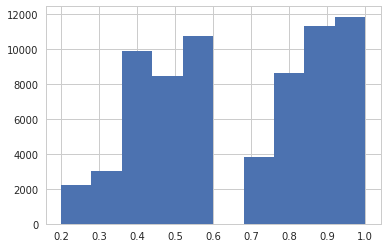

Unique y values:  [0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
Mean y value:  0.6802100000000001
Median y value:  0.7
Std y value:  0.23792000195143623


In [6]:
plt.hist(y_train)
plt.show()

print('Unique y values: ', np.unique(y_train))
print('Mean y value: ', np.mean(y_train))
print('Median y value: ', np.median(y_train))
print('Std y value: ', np.std(y_train))

Review length:
Mean 154.47 words (stddev: 81.134751)


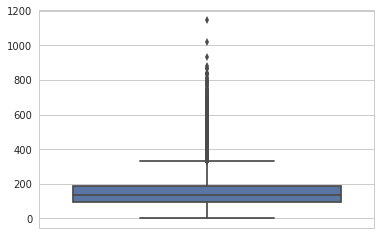

In [7]:
print('Review length:')
train_texts_lengths = [len(x.split(' ')) for x in X_train_texts]
print("Mean %.2f words (stddev: %f)" % \
      (np.mean(train_texts_lengths),
       np.std(train_texts_lengths)))

# plot review lengths
sns.boxplot(train_texts_lengths, orient='v')
plt.show()

In [8]:
# Tokenize the texts and keep only the top n words

TOP_WORDS = 10000

tokenizer = sis.create_tokenizer(X_train_texts, top_words=TOP_WORDS)

X_train = tokenizer.texts_to_sequences(X_train_texts)
X_val = tokenizer.texts_to_sequences(X_val_texts)
X_test = tokenizer.texts_to_sequences(X_test_texts)

print(len(X_train))
print(len(X_val))
print(len(X_test))

70000
3000
7000


In [9]:
index_to_token = {tokenizer.word_index[k]: k for k in tokenizer.word_index.keys()}

In [10]:
# Bound reviews at 500 words, truncating longer reviews and zero-padding shorter reviews

MAX_WORDS = 500

X_train = sis.pad_sequences(X_train, max_words=MAX_WORDS)
X_val = sis.pad_sequences(X_val, max_words=MAX_WORDS)
X_test = sis.pad_sequences(X_test, max_words=MAX_WORDS)

## Load trained CNN model

In [16]:
# Load a pre-trained model

model_path = '../trained_models/asp%d_cnn.hdf5' % ASPECT

model = load_model(model_path,
                   custom_objects={'coeff_determination_metric': sis.coeff_determination_metric})
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 500, 100)          1000000   
_________________________________________________________________
reshape_5 (Reshape)          (None, 500, 100, 1)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 498, 1, 128)       38528     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 1, 1, 128)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 1,038,657
Trainable params: 1,038,657
Non-trainable params: 0
_________________________________________________________________


In [66]:
# Evaluate model (for paper supplement)

train_preds = model.predict(X_train, verbose=1, batch_size=128)
val_preds = model.predict(X_val, verbose=1, batch_size=128)
test_preds = model.predict(X_test, verbose=1, batch_size=128)
annot_preds = model.predict(X_annotation, verbose=1, batch_size=128)

train_preds = train_preds.flatten()
val_preds = val_preds.flatten()
test_preds = test_preds.flatten()
annot_preds = annot_preds.flatten()

994/994 [==============================] - 0s 115us/step


In [67]:
# Compute MSE and R^2 for each set
train_mse = mean_squared_error(y_train, train_preds)
train_r2 = r2_score(y_train, train_preds)
train_correl = pearsonr(y_train, train_preds)[0]

val_mse = mean_squared_error(y_val, val_preds)
val_r2 = r2_score(y_val, val_preds)
val_correl = pearsonr(y_val, val_preds)[0]

test_mse = mean_squared_error(y_test, test_preds)
test_r2 = r2_score(y_test, test_preds)
test_correl = pearsonr(y_test, test_preds)[0]

annot_mse = mean_squared_error(y_annotation, annot_preds)
annot_r2 = r2_score(y_annotation, annot_preds)
annot_correl = pearsonr(y_annotation, annot_preds)[0]

# Rows for latex table
print('& Train & %d & %.3f & %.3f  \\\ ' % (len(X_train), train_mse, train_correl))
print('& Validation & %d & %.3f & %.3f  \\\ ' % (len(X_val), val_mse, val_correl))
print('& Test & %d & %.3f & %.3f  \\\ ' % (len(X_test), test_mse, test_correl))
print('& Annotation & %d & %.3f & %.3f  \\\ ' % (len(X_annotation), annot_mse, annot_correl))

& Train & 70000 & 0.016 & 0.850  \\ 
& Validation & 3000 & 0.025 & 0.748  \\ 
& Test & 7000 & 0.026 & 0.741  \\ 
& Annotation & 994 & 0.014 & 0.662  \\ 


## SIS Deletion Algorithm

In [21]:
from keras.models import load_model, Model, Sequential
from keras.layers import Input, Dense, Dropout, Flatten, Reshape, Conv2D, MaxPool2D
from sis import coeff_determination_metric

def make_text_cnn_model_feed_embeddings(max_words=500, embed_dim=100, num_filters=128, filter_size=3):
    model = Sequential()
    model.add(Reshape((500, 100, 1), input_shape=(max_words, embed_dim)))
    model.add(Conv2D(num_filters, kernel_size=(filter_size, 100), padding='valid', activation='relu'))
    model.add(MaxPool2D(pool_size=(500 - filter_size + 1, 1), padding='valid'))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='mse',
                  optimizer='adam',
                  metrics=['mse', 'mae', coeff_determination_metric])
    return model

def copy_layer_weights_text_cnn(from_model, to_model):
    to_model.layers[1].set_weights(from_model.layers[2].get_weights())  # Conv2D
    to_model.layers[-1].set_weights(from_model.layers[-1].get_weights())  # Dense output

In [22]:
embed_model = make_text_cnn_model_feed_embeddings()
copy_layer_weights_text_cnn(model, embed_model)
print(embed_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 500, 100, 1)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 498, 1, 128)       38528     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 38,657
Trainable params: 38,657
Non-trainable params: 0
_________________________________________________________________
None


In [23]:
# Make sure the models function the same, but testing the output for some input

embeddings = sis.get_embeddings(model)

X_new = embeddings[X_train[0]]

print(model.predict(np.array([X_train[0]])))
print(embed_model.predict(np.array(X_new).reshape((1, X_new.shape[0], X_new.shape[1]))))

[[0.8998619]]
[[0.8998619]]


In [24]:
# Try predicting the model on a series of all zeros
print('All zeros:',
      sis.predict_for_embed_sequence([np.zeros((500, 100))], embed_model))

# Try predicting the model on a series of all pad characters
pad_embedding = embeddings[0]
print('All pad:',
      sis.predict_for_embed_sequence([np.repeat(pad_embedding.reshape((1, pad_embedding.shape[0])), 500, axis=0)], embed_model))

# Try on a series of all mean embedding vectors
mean_embedding = np.mean(embeddings, axis=0)
print('All mean embedding:',
      sis.predict_for_embed_sequence([np.repeat(mean_embedding.reshape((1, mean_embedding.shape[0])), 500, axis=0)], embed_model))

All zeros: [0.53032404]
All pad: [0.6044966]
All mean embedding: [0.53773916]


## Load annotated examples

In [25]:
RATIONALE_ANNOTATION_PATH = os.path.join(BASE_PATH, 'annotations.json')
annotations = sis.load_rationale_annotations(RATIONALE_ANNOTATION_PATH)

Loaded 994 annotations.


In [26]:
X_annotation = [sis.retokenize_annotation(annot['x'], tokenizer)[0] for annot in annotations]
X_annotation = sis.pad_sequences(X_annotation)

y_annotation = np.array([float(annot['y'][ASPECT]) for annot in annotations])

In [27]:
# Count number of annotated rationales also present in training set

overlaps = 0
overlap_indices = []
X_annotation_set = set((tuple(x) for x in X_annotation))

for i, x in enumerate(X_train):
    if tuple(x) in X_annotation_set:
        overlaps += 1
    overlap_indices.append(i)

print('# Overlaps: ', overlaps)

# Overlaps:  0


## Determine which of the annotation examples are predicted "interesting"

In [38]:
original_predictions = model.predict(X_annotation)

Mean:  0.7325912
Median:  0.76067483
Stdev:  0.1465273

Num >= 0.85: 234
Num <= 0.45: 50


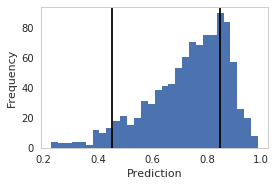

In [39]:
pos_threshold = 0.85
neg_threshold = 0.45

threshold_pos_f = lambda x: x >= pos_threshold
threshold_neg_f = lambda x: x <= neg_threshold

pos_example_idxs = np.flatnonzero(original_predictions >= pos_threshold)
neg_example_idxs = np.flatnonzero(original_predictions <= neg_threshold)

print('Mean: ', np.mean(original_predictions))
print('Median: ', np.median(original_predictions))
print('Stdev: ', np.std(original_predictions))
print('')
print('Num >= %.2f: %d' % (pos_threshold, len(pos_example_idxs)))
print('Num <= %.2f: %d' % (neg_threshold, len(neg_example_idxs)))

plt.figure(figsize=(4, 2.75))
plt.hist(original_predictions, bins=30)
plt.axvline(x=pos_threshold, c='black')
plt.axvline(x=neg_threshold, c='black')
plt.xlabel('Prediction')
plt.ylabel('Frequency')
plt.grid(False)
plt.tight_layout()
# plt.savefig(os.path.join(figures_dir, 'predictive_dist.png'), dpi=1200, bbox_inches='tight')
plt.show()

## Compute/load rationales on the "interesting" examples

In [24]:
BRC_DIR = '../rationale_results/beer_reviews/asp%d_cnn' % ASPECT

In [25]:
# Create new BeerReviewContainer
brc = BeerReviewContainer(embeddings, index_to_token, ASPECT, model_path, 0)

In [ ]:
# Load container and reviews/rationales from directory
brc = BeerReviewContainer.load_data(BRC_DIR)

In [26]:
# Create BeerReview objects from the existing data structures

for i in pos_example_idxs:
    x = X_annotation[i]
    review = BeerReview(x, i, embeddings=embeddings)
    annot_idxs = sis.get_annot_idxs(i, annotations, tokenizer, ASPECT)
    review.set_annotation_idxs(annot_idxs)
    review.threshold = pos_threshold
    review.threshold_f = threshold_pos_f
    review.is_pos = True
    brc.add_pos_review(review)

for i in neg_example_idxs:
    x = X_annotation[i]
    review = BeerReview(x, i, embeddings=embeddings)
    annot_idxs = sis.get_annot_idxs(i, annotations, tokenizer, ASPECT)
    review.set_annotation_idxs(annot_idxs)
    review.threshold = neg_threshold
    review.threshold_f = threshold_neg_f
    review.is_pos = False
    brc.add_neg_review(review)

In [27]:
%%time
# Compute all SIS rationales for each review
for review in brc.get_all_reviews():
    review.run_sis_rationales(embed_model, first_only=False, verbose=False)

CPU times: user 27min 25s, sys: 21min, total: 48min 26s
Wall time: 55min 8s


In [30]:
%%time
# Run integrated gradients on all reviews
for r in brc.get_all_reviews():
    r.run_integrated_gradients_rationale(ig, embed_model, igs_baseline)

CPU times: user 13.2 s, sys: 5.66 s, total: 18.9 s
Wall time: 20.1 s


In [31]:
# Compute predictions on (non/)rationales only, (non/)annotations only, etc.
#   Only mask first rationale in rationale hold-outs
for r in brc.get_all_reviews():
    rationales = [r.get_rationales(SIS_RATIONALE_KEY)[0]]  # only first rationale for masking
    r.set_predictions(embed_model, rationales)

In [36]:
# Dump container and all reviews/rationales to directory
brc.dump_data(BRC_DIR)

## Analysis of Rationale lengths

In [42]:
rationale_len_sis_pos = np.array([len(r.get_rationales(SIS_RATIONALE_KEY)[0]) \
                                         for r in brc.get_pos_reviews()])
rationale_len_sis_neg = np.array([len(r.get_rationales(SIS_RATIONALE_KEY)[0]) \
                                         for r in brc.get_neg_reviews()])

rationale_len_sis = np.concatenate((rationale_len_sis_pos, rationale_len_sis_neg))

rationale_len_sis_pos_percentage = np.array([len(r.get_rationales(SIS_RATIONALE_KEY)[0]) / \
                                                 float(r.get_num_tokens()) * 100.0 \
                                                 for r in brc.get_pos_reviews()])
rationale_len_sis_neg_percentage = np.array([len(r.get_rationales(SIS_RATIONALE_KEY)[0]) / \
                                                 float(r.get_num_tokens()) * 100.0 \
                                                 for r in brc.get_neg_reviews()])

rationale_len_sis_percentage = np.concatenate((rationale_len_sis_pos_percentage, \
                                                  rationale_len_sis_neg_percentage))

rationale_len_sis_percentage_allsuffic = []
for review in brc.get_all_reviews():
    num_tokens = review.get_num_tokens()
    for r in review.get_rationales(SIS_RATIONALE_KEY):
        rationale_len_sis_percentage_allsuffic.append(len(r) / float(num_tokens) * 100.0)
rationale_len_sis_percentage_allsuffic = np.array(rationale_len_sis_percentage_allsuffic)

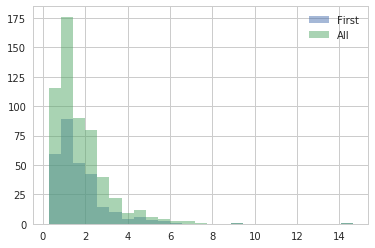

In [43]:
plt.hist(rationale_len_sis_percentage, bins=25, alpha=0.5, label='First')
plt.hist(rationale_len_sis_percentage_allsuffic, bins=25, alpha=0.5, label='All')
plt.legend(loc='upper right')
plt.show()

Rationale Lengths, SIS:
Mean:  1.6619718309859155
Median:  1.0
Stdev:  0.8507438662529809
Min:  1
Max:  6


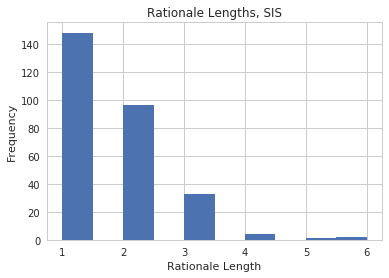

Rationale Lengths, SIS (as percentage of input length):
Mean:  1.738208299956643
Median:  1.3559477845192132
Stdev:  1.3817843477245788
Min:  0.2652519893899204
Max:  14.634146341463413


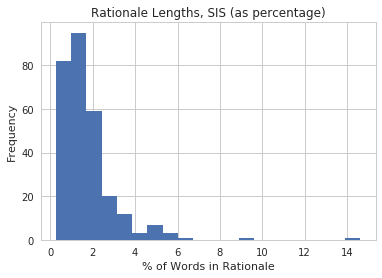

In [44]:
print('Rationale Lengths, SIS:')
print('Mean: ', np.mean(rationale_len_sis))
print('Median: ', np.median(rationale_len_sis))
print('Stdev: ', np.std(rationale_len_sis))
print('Min: ', np.min(rationale_len_sis))
print('Max: ', np.max(rationale_len_sis))

plt.hist(rationale_len_sis, bins=10)
plt.xlabel('Rationale Length')
plt.ylabel('Frequency')
plt.title('Rationale Lengths, SIS')
plt.show()

print('Rationale Lengths, SIS (as percentage of input length):')
print('Mean: ', np.mean(rationale_len_sis_percentage))
print('Median: ', np.median(rationale_len_sis_percentage))
print('Stdev: ', np.std(rationale_len_sis_percentage))
print('Min: ', np.min(rationale_len_sis_percentage))
print('Max: ', np.max(rationale_len_sis_percentage))

plt.hist(rationale_len_sis_percentage, bins=20)
plt.xlabel('% of Words in Rationale')
plt.ylabel('Frequency')
plt.title('Rationale Lengths, SIS (as percentage)')
plt.show()

In [45]:
rationale_len_ig_pos = np.array([len(r.get_rationales(IG_SUFF_RATIONALE_KEY)[0]) for r in brc.get_pos_reviews()])
rationale_len_ig_neg = np.array([len(r.get_rationales(IG_SUFF_RATIONALE_KEY)[0]) for r in brc.get_neg_reviews()])

rationale_len_ig = np.concatenate((rationale_len_ig_pos, rationale_len_ig_neg))

rationale_len_ig_pos_percentage = np.array([len(r.get_rationales(IG_SUFF_RATIONALE_KEY)[0]) / \
                                                float(r.get_num_tokens()) * 100.0 \
                                                 for r in brc.get_pos_reviews()])
rationale_len_ig_neg_percentage = np.array([len(r.get_rationales(IG_SUFF_RATIONALE_KEY)[0]) / \
                                                 float(r.get_num_tokens()) * 100.0 \
                                                 for r in brc.get_neg_reviews()])

rationale_len_ig_percentage = np.concatenate((rationale_len_ig_pos_percentage, \
                                              rationale_len_ig_neg_percentage))

Rationale Lengths, Integrated Gradients:
Mean:  6.232394366197183
Median:  3.0
Stdev:  8.609416309866075
Min:  1
Max:  45


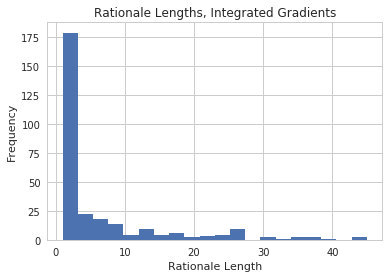

Rationale Lengths, Integrated Gradients (as percentage of input length):
Mean:  6.258558684117604
Median:  2.3575729504400185
Stdev:  9.226777888545062
Min:  0.2652519893899204
Max:  60.3448275862069


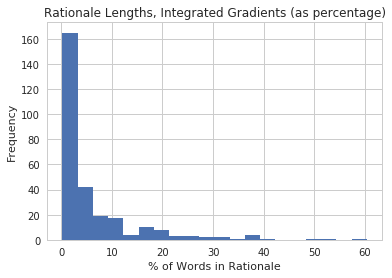

In [46]:
print('Rationale Lengths, Integrated Gradients:')
print('Mean: ', np.mean(rationale_len_ig))
print('Median: ', np.median(rationale_len_ig))
print('Stdev: ', np.std(rationale_len_ig))
print('Min: ', np.min(rationale_len_ig))
print('Max: ', np.max(rationale_len_ig))

plt.hist(rationale_len_ig, bins=20)
plt.xlabel('Rationale Length')
plt.ylabel('Frequency')
plt.title('Rationale Lengths, Integrated Gradients')
plt.show()

print('Rationale Lengths, Integrated Gradients (as percentage of input length):')
print('Mean: ', np.mean(rationale_len_ig_percentage))
print('Median: ', np.median(rationale_len_ig_percentage))
print('Stdev: ', np.std(rationale_len_ig_percentage))
print('Min: ', np.min(rationale_len_ig_percentage))
print('Max: ', np.max(rationale_len_ig_percentage))

plt.hist(rationale_len_ig_percentage, bins=20)
plt.xlabel('% of Words in Rationale')
plt.ylabel('Frequency')
plt.title('Rationale Lengths, Integrated Gradients (as percentage)')
plt.show()

In [47]:
rationale_len_lime_pos = np.array([len(r.get_rationales(LIME_SUFF_RATIONALE_KEY)[0]) for r in brc.get_pos_reviews()])
rationale_len_lime_neg = np.array([len(r.get_rationales(LIME_SUFF_RATIONALE_KEY)[0]) for r in brc.get_neg_reviews()])

rationale_len_lime = np.concatenate((rationale_len_lime_pos, rationale_len_lime_neg))

rationale_len_lime_pos_percentage = np.array([len(r.get_rationales(LIME_SUFF_RATIONALE_KEY)[0]) / \
                                                float(r.get_num_tokens()) * 100.0 \
                                                 for r in brc.get_pos_reviews()])
rationale_len_lime_neg_percentage = np.array([len(r.get_rationales(LIME_SUFF_RATIONALE_KEY)[0]) / \
                                                 float(r.get_num_tokens()) * 100.0 \
                                                 for r in brc.get_neg_reviews()])

rationale_len_lime_percentage = np.concatenate((rationale_len_lime_pos_percentage, \
                                                rationale_len_lime_neg_percentage))

Rationale Lengths, LIME:
Mean:  8.690140845070422
Median:  2.0
Stdev:  16.579804063892436
Min:  1
Max:  101


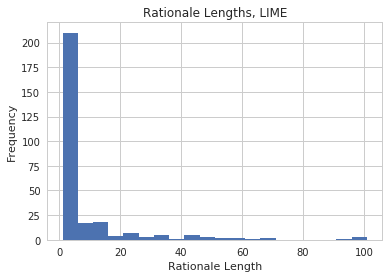

Rationale Lengths, LIME (as percentage of input length):
Mean:  8.792409390344869
Median:  2.127659574468085
Stdev:  16.943097942626974
Min:  0.39215686274509803
Max:  100.0


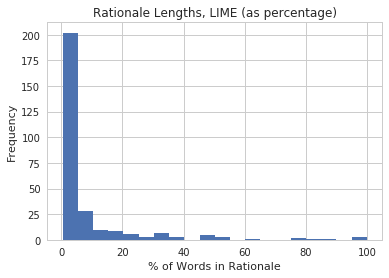

In [48]:
print('Rationale Lengths, LIME:')
print('Mean: ', np.mean(rationale_len_lime))
print('Median: ', np.median(rationale_len_lime))
print('Stdev: ', np.std(rationale_len_lime))
print('Min: ', np.min(rationale_len_lime))
print('Max: ', np.max(rationale_len_lime))

plt.hist(rationale_len_lime, bins=20)
plt.xlabel('Rationale Length')
plt.ylabel('Frequency')
plt.title('Rationale Lengths, LIME')
plt.show()

print('Rationale Lengths, LIME (as percentage of input length):')
print('Mean: ', np.mean(rationale_len_lime_percentage))
print('Median: ', np.median(rationale_len_lime_percentage))
print('Stdev: ', np.std(rationale_len_lime_percentage))
print('Min: ', np.min(rationale_len_lime_percentage))
print('Max: ', np.max(rationale_len_lime_percentage))

plt.hist(rationale_len_lime_percentage, bins=20)
plt.xlabel('% of Words in Rationale')
plt.ylabel('Frequency')
plt.title('Rationale Lengths, LIME (as percentage)')
plt.show()

In [49]:
rationale_len_pert_pos = np.array([len(r.get_rationales(PERTURB_SUFF_RATIONALE_KEY)[0]) for r in brc.get_pos_reviews()])
rationale_len_pert_neg = np.array([len(r.get_rationales(PERTURB_SUFF_RATIONALE_KEY)[0]) for r in brc.get_neg_reviews()])

rationale_len_pert = np.concatenate((rationale_len_pert_pos, rationale_len_pert_neg))

rationale_len_pert_pos_percentage = np.array([len(r.get_rationales(PERTURB_SUFF_RATIONALE_KEY)[0]) / \
                                                float(r.get_num_tokens()) * 100.0 \
                                                 for r in brc.get_pos_reviews()])
rationale_len_pert_neg_percentage = np.array([len(r.get_rationales(PERTURB_SUFF_RATIONALE_KEY)[0]) / \
                                                 float(r.get_num_tokens()) * 100.0 \
                                                 for r in brc.get_neg_reviews()])

rationale_len_pert_percentage = np.concatenate((rationale_len_pert_pos_percentage, \
                                                rationale_len_pert_neg_percentage))

Rationale Lengths, Perturbative Baseline:
Mean:  2.971830985915493
Median:  2.0
Stdev:  2.1606065331643682
Min:  1
Max:  13


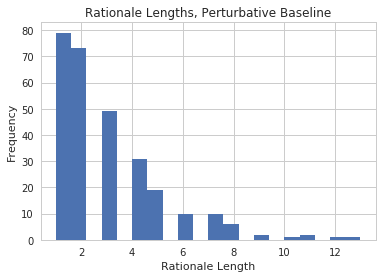

Rationale Lengths, Perturbative Baseline (as percentage of input length):
Mean:  3.0653011298368655
Median:  2.272727272727273
Stdev:  2.8344530155187115
Min:  0.39215686274509803
Max:  19.672131147540984


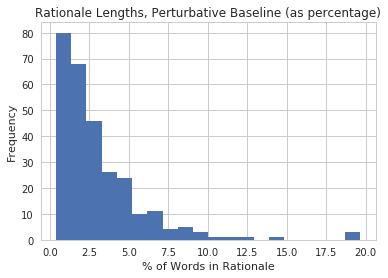

In [50]:
print('Rationale Lengths, Perturbative Baseline:')
print('Mean: ', np.mean(rationale_len_pert))
print('Median: ', np.median(rationale_len_pert))
print('Stdev: ', np.std(rationale_len_pert))
print('Min: ', np.min(rationale_len_pert))
print('Max: ', np.max(rationale_len_pert))

plt.hist(rationale_len_pert, bins=20)
plt.xlabel('Rationale Length')
plt.ylabel('Frequency')
plt.title('Rationale Lengths, Perturbative Baseline')
plt.show()

print('Rationale Lengths, Perturbative Baseline (as percentage of input length):')
print('Mean: ', np.mean(rationale_len_pert_percentage))
print('Median: ', np.median(rationale_len_pert_percentage))
print('Stdev: ', np.std(rationale_len_pert_percentage))
print('Min: ', np.min(rationale_len_pert_percentage))
print('Max: ', np.max(rationale_len_pert_percentage))

plt.hist(rationale_len_pert_percentage, bins=20)
plt.xlabel('% of Words in Rationale')
plt.ylabel('Frequency')
plt.title('Rationale Lengths, Perturbative Baseline (as percentage)')
plt.show()

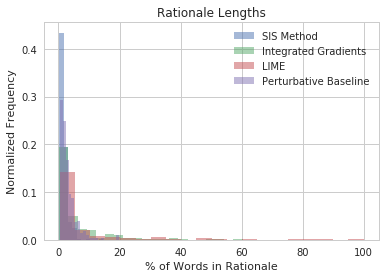

In [51]:
plt.hist(rationale_len_sis_percentage, bins=10, density=True, alpha=0.5, label='SIS Method')
plt.hist(rationale_len_ig_percentage, bins=20, density=True, alpha=0.5, label='Integrated Gradients')
plt.hist(rationale_len_lime_percentage, bins=20, density=True, alpha=0.5, label='LIME')
plt.hist(rationale_len_pert_percentage, bins=20, density=True, alpha=0.5, label='Perturbative Baseline')

plt.xlabel('% of Words in Rationale')
plt.ylabel('Normalized Frequency')
plt.title('Rationale Lengths')
plt.legend(loc='upper right')
plt.show()

In [52]:
# Fixed Length baselines

# IG 
rationale_len_fixed_length_ig_pos = np.array([len(r.get_rationales(IG_FIXED_RATIONALE_KEY)[0]) for r in brc.get_pos_reviews()])
rationale_len_fixed_length_ig_neg = np.array([len(r.get_rationales(IG_FIXED_RATIONALE_KEY)[0]) for r in brc.get_neg_reviews()])

rationale_len_fixed_length_ig = np.concatenate((rationale_len_fixed_length_ig_pos, rationale_len_fixed_length_ig_neg))

rationale_len_fixed_length_ig_pos_percentage = np.array([len(r.get_rationales(IG_FIXED_RATIONALE_KEY)[0]) / \
                                                float(r.get_num_tokens()) * 100.0 \
                                                 for r in brc.get_pos_reviews()])
rationale_len_fixed_length_ig_neg_percentage = np.array([len(r.get_rationales(IG_FIXED_RATIONALE_KEY)[0]) / \
                                                 float(r.get_num_tokens()) * 100.0 \
                                                 for r in brc.get_neg_reviews()])

rationale_len_fixed_length_ig_percentage = np.concatenate((rationale_len_fixed_length_ig_pos_percentage, \
                                                           rationale_len_fixed_length_ig_neg_percentage))

# LIME
rationale_len_fixed_length_lime_pos = np.array([len(r.get_rationales(LIME_FIXED_RATIONALE_KEY)[0]) for r in brc.get_pos_reviews()])
rationale_len_fixed_length_lime_neg = np.array([len(r.get_rationales(LIME_FIXED_RATIONALE_KEY)[0]) for r in brc.get_neg_reviews()])

rationale_len_fixed_length_lime = np.concatenate((rationale_len_fixed_length_lime_pos, rationale_len_fixed_length_lime_neg))

rationale_len_fixed_length_lime_pos_percentage = np.array([len(r.get_rationales(LIME_FIXED_RATIONALE_KEY)[0]) / \
                                                float(r.get_num_tokens()) * 100.0 \
                                                 for r in brc.get_pos_reviews()])
rationale_len_fixed_length_lime_neg_percentage = np.array([len(r.get_rationales(LIME_FIXED_RATIONALE_KEY)[0]) / \
                                                 float(r.get_num_tokens()) * 100.0 \
                                                 for r in brc.get_neg_reviews()])

rationale_len_fixed_length_lime_percentage = np.concatenate((rationale_len_fixed_length_lime_pos_percentage, \
                                                             rationale_len_fixed_length_lime_neg_percentage))

# Perturb.
rationale_len_fixed_length_pert_pos = np.array([len(r.get_rationales(PERTURB_FIXED_RATIONALE_KEY)[0]) for r in brc.get_pos_reviews()])
rationale_len_fixed_length_pert_neg = np.array([len(r.get_rationales(PERTURB_FIXED_RATIONALE_KEY)[0]) for r in brc.get_neg_reviews()])

rationale_len_fixed_length_pert = np.concatenate((rationale_len_fixed_length_pert_pos, rationale_len_fixed_length_pert_neg))

rationale_len_fixed_length_pert_pos_percentage = np.array([len(r.get_rationales(PERTURB_FIXED_RATIONALE_KEY)[0]) / \
                                                float(r.get_num_tokens()) * 100.0 \
                                                 for r in brc.get_pos_reviews()])
rationale_len_fixed_length_pert_neg_percentage = np.array([len(r.get_rationales(PERTURB_FIXED_RATIONALE_KEY)[0]) / \
                                                 float(r.get_num_tokens()) * 100.0 \
                                                 for r in brc.get_neg_reviews()])

rationale_len_fixed_length_pert_percentage = np.concatenate((rationale_len_fixed_length_pert_pos_percentage, \
                                                             rationale_len_fixed_length_pert_neg_percentage))

In [53]:
columns = ['method', 'rationale_length']

rationale_len_df = pd.DataFrame.from_dict({'SIS': rationale_len_sis_percentage_allsuffic,
                                           'Suff. IG': rationale_len_ig_percentage,
                                           'Suff. LIME': rationale_len_lime_percentage,
                                           'Suff. Perturb.': rationale_len_pert_percentage,
                                           'IG': rationale_len_fixed_length_ig_percentage,
                                           'LIME': rationale_len_fixed_length_lime_percentage,
                                           'Perturb.': rationale_len_fixed_length_pert_percentage,},
                                          orient='index').transpose()

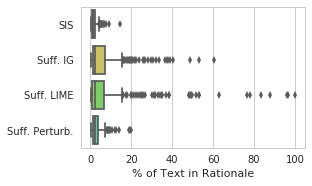

In [54]:
plt.figure(figsize=(4.5, 2.75))
sns.boxplot(data=rationale_len_df, orient='h', order=['SIS', 'Suff. IG', 'Suff. LIME', 'Suff. Perturb.'], # 'IG', 'LIME', 'Perturb.']
            palette=sns.color_palette('hls', 7))
plt.xlabel('% of Text in Rationale')
plt.tight_layout()
# plt.savefig(os.path.join(figures_dir, 'rationale_lengths.png'), dpi=1200, bbox_inches='tight')
plt.show()

In [55]:
# Dump table rows for paper

stats_baseline = rationale_len_sis_percentage
float_formatter = '%.1f'

for title, vals in [('SIS', rationale_len_sis_percentage), ('Suff. IG', rationale_len_ig_percentage),
                    ('Suff. LIME', rationale_len_lime_percentage), ('Suff. Perturb.', rationale_len_pert_percentage)]:
    vals_median = float_formatter % np.median(vals) + '\%'
    vals_max = float_formatter % np.max(vals) + '\%'
    stat, p = ranksums(stats_baseline, vals)
    if p == 1:
        p = '--'
    else:
        p = '%.0e' % p
    data = [title, vals_median, vals_max, p]
    tex = ' & '.join(data)
    tex += ' &'
    print(tex)

SIS & 1.4\% & 14.6\% & -- &
Suff. IG & 2.4\% & 60.3\% & 2e-14 &
Suff. LIME & 2.1\% & 100.0\% & 9e-11 &
Suff. Perturb. & 2.3\% & 19.7\% & 4e-13 &


## Fraction of rationales in sentence-level annotations

In [56]:
frac_in_annots_sis_pos = np.array([r.frac_rationale_in_annotation([r.get_rationales(SIS_RATIONALE_KEY)[0]]) \
                                          for r in brc.get_pos_reviews() if r.has_annotation()])
frac_in_annots_sis_neg = np.array([r.frac_rationale_in_annotation([r.get_rationales(SIS_RATIONALE_KEY)[0]]) \
                                          for r in brc.get_neg_reviews() if r.has_annotation()])

frac_in_annots_sis = np.concatenate((frac_in_annots_sis_pos, frac_in_annots_sis_neg))

Mean:  0.5370987654320987
Median:  1.0
Stdev:  0.48636048473286453


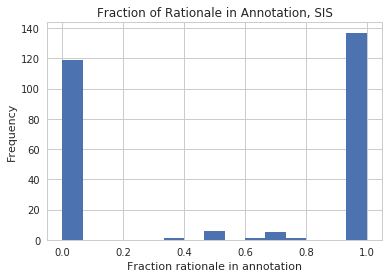

In [57]:
print('Mean: ', np.mean(frac_in_annots_sis))
print('Median: ', np.median(frac_in_annots_sis))
print('Stdev: ', np.std(frac_in_annots_sis))

plt.hist(frac_in_annots_sis, bins=15)
plt.title('Fraction of Rationale in Annotation, SIS')
plt.xlabel('Fraction rationale in annotation')
plt.ylabel('Frequency')
plt.show()

rationale_lens_sis_annotonly = np.array([len(r.get_rationales(SIS_RATIONALE_KEY)[0]) / \
                                                float(r.get_num_tokens()) * 100.0 \
                                                for r in brc.get_all_reviews() if r.has_annotation()])

In [58]:
frac_in_annots_ig_pos = np.array([r.frac_rationale_in_annotation([r.get_rationales(IG_SUFF_RATIONALE_KEY)[0]]) \
                                          for r in brc.get_pos_reviews() if r.has_annotation()])
frac_in_annots_ig_neg = np.array([r.frac_rationale_in_annotation([r.get_rationales(IG_SUFF_RATIONALE_KEY)[0]]) \
                                          for r in brc.get_neg_reviews() if r.has_annotation()])

frac_in_annots_ig = np.concatenate((frac_in_annots_ig_pos, frac_in_annots_ig_neg))

Mean:  0.6849724334821952
Median:  0.8516483516483516
Stdev:  0.3663866972247005


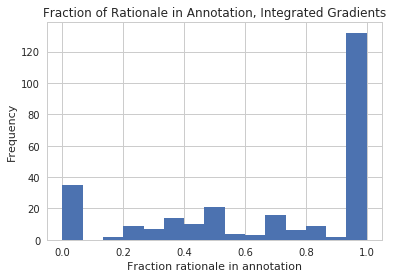

In [59]:
print('Mean: ', np.mean(frac_in_annots_ig))
print('Median: ', np.median(frac_in_annots_ig))
print('Stdev: ', np.std(frac_in_annots_ig))

plt.hist(frac_in_annots_ig, bins=15)
plt.title('Fraction of Rationale in Annotation, Integrated Gradients')
plt.xlabel('Fraction rationale in annotation')
plt.ylabel('Frequency')
plt.show()

rationale_lens_ig_annotonly = np.array([len(r.get_rationales(IG_SUFF_RATIONALE_KEY)[0]) / \
                                            float(r.get_num_tokens()) * 100.0 \
                                            for r in brc.get_all_reviews() if r.has_annotation()])

In [60]:
frac_in_annots_lime_pos = np.array([r.frac_rationale_in_annotation([r.get_rationales(LIME_SUFF_RATIONALE_KEY)[0]]) \
                                          for r in brc.get_pos_reviews() if r.has_annotation()])
frac_in_annots_lime_neg = np.array([r.frac_rationale_in_annotation([r.get_rationales(LIME_SUFF_RATIONALE_KEY)[0]]) \
                                          for r in brc.get_neg_reviews() if r.has_annotation()])

frac_in_annots_lime = np.concatenate((frac_in_annots_lime_pos, frac_in_annots_lime_neg))

Mean:  0.6252128711018347
Median:  0.6666666666666666
Stdev:  0.38200146979458083


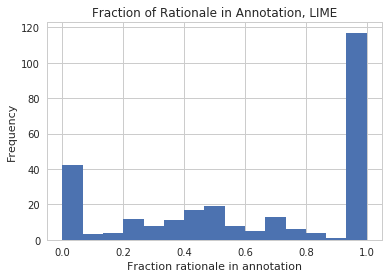

In [61]:
print('Mean: ', np.mean(frac_in_annots_lime))
print('Median: ', np.median(frac_in_annots_lime))
print('Stdev: ', np.std(frac_in_annots_lime))

plt.hist(frac_in_annots_lime, bins=15)
plt.title('Fraction of Rationale in Annotation, LIME')
plt.xlabel('Fraction rationale in annotation')
plt.ylabel('Frequency')
plt.show()

rationale_lens_lime_annotonly = np.array([len(r.get_rationales(LIME_SUFF_RATIONALE_KEY)[0]) / \
                                            float(r.get_num_tokens()) * 100.0 \
                                            for r in brc.get_all_reviews() if r.has_annotation()])

In [62]:
frac_in_annots_pert_pos = np.array([r.frac_rationale_in_annotation([r.get_rationales(PERTURB_SUFF_RATIONALE_KEY)[0]]) \
                                          for r in brc.get_pos_reviews() if r.has_annotation()])
frac_in_annots_pert_neg = np.array([r.frac_rationale_in_annotation([r.get_rationales(PERTURB_SUFF_RATIONALE_KEY)[0]]) \
                                          for r in brc.get_neg_reviews() if r.has_annotation()])

frac_in_annots_pert = np.concatenate((frac_in_annots_pert_pos, frac_in_annots_pert_neg))

Mean:  0.7471513568735791
Median:  1.0
Stdev:  0.34621404978193676


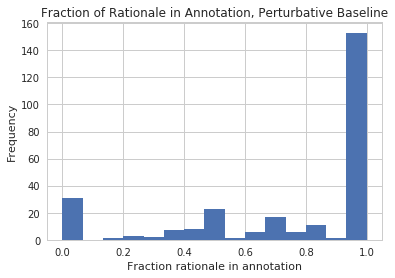

In [63]:
print('Mean: ', np.mean(frac_in_annots_pert))
print('Median: ', np.median(frac_in_annots_pert))
print('Stdev: ', np.std(frac_in_annots_pert))

plt.hist(frac_in_annots_pert, bins=15)
plt.title('Fraction of Rationale in Annotation, Perturbative Baseline')
plt.xlabel('Fraction rationale in annotation')
plt.ylabel('Frequency')
plt.show()

rationale_lens_pert_annotonly = np.array([len(r.get_rationales(PERTURB_SUFF_RATIONALE_KEY)[0]) / \
                                            float(r.get_num_tokens()) * 100.0 \
                                            for r in brc.get_all_reviews() if r.has_annotation()])

/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


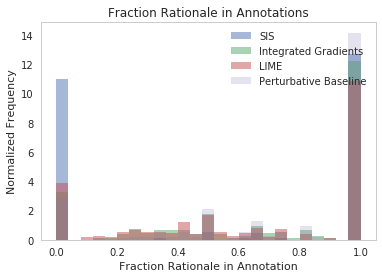

In [65]:
plt.hist(frac_in_annots_sis, normed=True, bins=25, alpha=0.5, label='SIS')
plt.hist(frac_in_annots_ig, normed=True, bins=25, alpha=0.5, label='Integrated Gradients')
plt.hist(frac_in_annots_lime, normed=True, bins=25, alpha=0.5, label='LIME')
plt.hist(frac_in_annots_pert, normed=True, bins=25, alpha=0.2, label='Perturbative Baseline')

plt.xlabel('Fraction Rationale in Annotation')
plt.ylabel('Normalized Frequency')
plt.title('Fraction Rationale in Annotations')
plt.legend(loc='upper right')
plt.grid(False)
plt.show()

In [66]:
# Statistical test comparing the distributions

print('SIS vs. Integrated Gradients:')
print(ttest_ind(frac_in_annots_sis, frac_in_annots_ig, equal_var=False))
print(ranksums(frac_in_annots_sis, frac_in_annots_ig))

print('\nSIS vs. LIME:')
print(ttest_ind(frac_in_annots_sis, frac_in_annots_lime, equal_var=False))
print(ranksums(frac_in_annots_sis, frac_in_annots_lime))

print('\nSIS vs. Perturbative Baseline:')
print(ttest_ind(frac_in_annots_sis, frac_in_annots_pert, equal_var=False))
print(ranksums(frac_in_annots_sis, frac_in_annots_pert))

SIS vs. Integrated Gradients:
Ttest_indResult(statistic=-3.9829557201998833, pvalue=7.817719667293248e-05)
RanksumsResult(statistic=-2.790845704075805, pvalue=0.005257052647556818)

SIS vs. LIME:
Ttest_indResult(statistic=-2.3368022187106394, pvalue=0.019836118112205505)
RanksumsResult(statistic=-1.8368447859615438, pvalue=0.06623281222148787)

SIS vs. Perturbative Baseline:
Ttest_indResult(statistic=-5.770704333206712, pvalue=1.4077700499421702e-08)
RanksumsResult(statistic=-3.8888155378465115, pvalue=0.00010073464212012884)


## Quality of annotations analysis

In [67]:
annots_only_preds_pos = np.array([r.prediction_annotation_only for r in brc.get_pos_reviews() \
                                      if r.has_annotation()])
annots_only_preds_neg = np.array([r.prediction_annotation_only for r in brc.get_neg_reviews() \
                                      if r.has_annotation()])

annots_only_preds_pos_deltas = np.array([r.prediction_annotation_only - r.original_prediction \
                                             for r in brc.get_pos_reviews() if r.has_annotation()])
annots_only_preds_neg_deltas = np.array([r.original_prediction - r.prediction_annotation_only \
                                             for r in brc.get_neg_reviews() if r.has_annotation()])

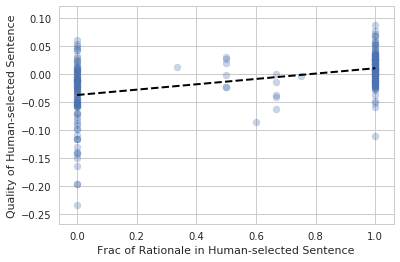

SpearmanrResult(correlation=0.4890085019672671, pvalue=2.732333548287982e-15)
Pearson r, p: (0.47192708310318465, 3.256661844765968e-14)
LinregressResult(slope=0.047804160352567925, intercept=-0.03744140235080255, rvalue=0.47192707052236843, pvalue=3.2566676249881984e-14, stderr=0.005901510201030138)


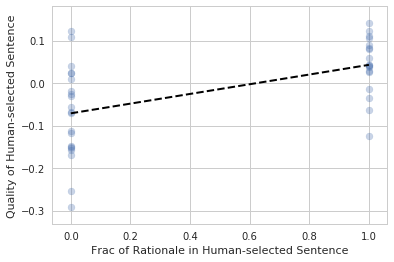

SpearmanrResult(correlation=0.562118709534759, pvalue=0.0001960366244311609)
Pearson r, p: (0.5356524552806319, 0.00044122360661031626)
LinregressResult(slope=0.11411407116859679, intercept=-0.07118025762557766, rvalue=0.5356524647482479, pvalue=0.00044122348380163854, stderr=0.02957489918803042)


In [68]:
plt.scatter(frac_in_annots_sis_pos, annots_only_preds_pos_deltas, alpha=0.3)
plt.plot(np.unique(frac_in_annots_sis_pos),
         np.poly1d(np.polyfit(frac_in_annots_sis_pos,
                              annots_only_preds_pos_deltas, 1))(np.unique(frac_in_annots_sis_pos)),
         '--', c='black', linewidth=2)
plt.xlabel('Frac of Rationale in Human-selected Sentence')
#plt.ylabel('pred on annotation only - original prediction')
plt.ylabel('Quality of Human-selected Sentence')
#plt.title('Effect of Quality of Annotations on Rationale Interpretability, Pos. SIS')
plt.show()

print(spearmanr(frac_in_annots_sis_pos, annots_only_preds_pos_deltas))
print('Pearson r, p:', pearsonr(frac_in_annots_sis_pos, annots_only_preds_pos_deltas))
print(linregress(frac_in_annots_sis_pos, annots_only_preds_pos_deltas))


plt.scatter(frac_in_annots_sis_neg, annots_only_preds_neg_deltas, alpha=0.3)
plt.plot(np.unique(frac_in_annots_sis_neg),
         np.poly1d(np.polyfit(frac_in_annots_sis_neg,
                              annots_only_preds_neg_deltas, 1))(np.unique(frac_in_annots_sis_neg)),
         '--', c='black', linewidth=2)
plt.xlabel('Frac of Rationale in Human-selected Sentence')
#plt.ylabel('original prediction - pred on annotation only')
plt.ylabel('Quality of Human-selected Sentence')
#plt.title('Effect of Quality of Annotations on Rationale Interpretability, Neg. SIS')
plt.show()

print(spearmanr(frac_in_annots_sis_neg, annots_only_preds_neg_deltas))
print('Pearson r, p:', pearsonr(frac_in_annots_sis_neg, annots_only_preds_neg_deltas))
print(linregress(frac_in_annots_sis_neg, annots_only_preds_neg_deltas))

In [69]:
# For paper, positive and negative examples together,
#   with all sufficient rationales for each example (as independent points)

frac_in_annots_sis_allsuffic = []
quality_of_annotations_allsuffic = []

for review in brc.get_all_reviews():
    if not review.has_annotation():
        continue
    annot_only_pred_delta = review.prediction_annotation_only - review.original_prediction
    if not review.is_pos:  # if negative, want review.original_prediction - review.prediction_annotation_only
        annot_only_pred_delta *= -1
    for r in review.get_rationales(SIS_RATIONALE_KEY):
        frac_in_annots_sis_allsuffic.append(review.frac_rationale_in_annotation([r]))
        quality_of_annotations_allsuffic.append(annot_only_pred_delta)

frac_in_annots_sis_allsuffic = np.array(frac_in_annots_sis_allsuffic)
quality_of_annotations_allsuffic = np.array(quality_of_annotations_allsuffic)

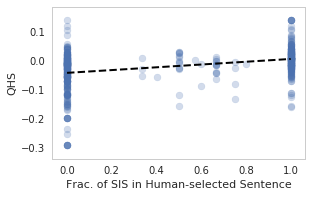

SpearmanrResult(correlation=0.39746199486517403, pvalue=1.1791156710178384e-21)
Pearson r, p: (0.36923890017184174, 1.0814426125798333e-18)
LinregressResult(slope=0.048044634529004066, intercept=-0.04071861450521727, rvalue=0.3692389001718417, pvalue=1.081442612579711e-18, stderr=0.005242684156831964)


In [70]:
# Positive and negative examples together, with all sufficient rationales as separate points (same y value)

plt.figure(figsize=(4.5, 2.9))
plt.scatter(frac_in_annots_sis_allsuffic, quality_of_annotations_allsuffic, alpha=0.25)
plt.plot(np.unique(frac_in_annots_sis_allsuffic),
         np.poly1d(np.polyfit(frac_in_annots_sis_allsuffic,
                              quality_of_annotations_allsuffic, 1))(np.unique(frac_in_annots_sis_allsuffic)),
         '--', c='black', linewidth=2)
plt.xlabel('Frac. of SIS in Human-selected Sentence')
plt.ylabel('QHS')
#plt.ylabel('Quality of Human-selected Sentence')
plt.grid(False)
plt.tight_layout()
# plt.savefig(os.path.join(figures_dir, 'quality_sentence_vs_frac.png'), dpi=1200, bbox_inches='tight')
plt.show()

print(spearmanr(frac_in_annots_sis_allsuffic, quality_of_annotations_allsuffic))
print('Pearson r, p:', pearsonr(frac_in_annots_sis_allsuffic, quality_of_annotations_allsuffic))
print(linregress(frac_in_annots_sis_allsuffic, quality_of_annotations_allsuffic))

In [71]:
# Highlight examples where the model's decision-making aligned with human annotation and where it didn't

idxs_with_annots_pos = np.array([r.i for r in brc.get_pos_reviews() if r.has_annotation()])
assert(len(idxs_with_annots_pos) == len(frac_in_annots_sis_pos) == len(annots_only_preds_pos_deltas))
upper_right_examples = idxs_with_annots_pos[np.logical_and(
                                              frac_in_annots_sis_pos == 1,
                                              annots_only_preds_pos_deltas >= -0.01)]
# upper_right_reviews = [brc.get_review(i) for i in upper_right_examples]
print('Good example i\'s: ', upper_right_examples)

lower_left_examples = idxs_with_annots_pos[np.logical_and(
                                              frac_in_annots_sis_pos == 0.0,
                                              annots_only_preds_pos_deltas <= -0.3)]
# lower_left_reviews = [brc.get_review(i) for i in upper_right_examples]
print('Misaligned example i\'s: ', lower_left_examples)

Good example i's:  [  5  17  23  30  34  48 100 105 118 127 155 161 187 204 241 247 283 316
 323 327 342 346 362 364 369 372 374 383 385 389 400 401 409 418 426 481
 486 508 591 594 595 613 616 617 621 627 631 643 645 651 653 656 661 672
 686 740 742 745 753 760 772 775 779 819 822 841 842 862 864 866 870 887
 892 895 900 902 905 911 918 922 925 931 956 960 962 968 970 971 972 977
 992 993]
Misaligned example i's:  []


In [72]:
# Print 5
# Also print quality of annotation score.

html = ''

for i in [5]:
    #html += '<p style="text-align:justify;">'
    review = brc.get_review(i)
    qha = review.prediction_annotation_only - review.original_prediction
    html += visualizations.highlight_multi_rationale(review, review.get_rationales(SIS_RATIONALE_KEY),
                                                     index_to_token)
    print('Example %d:' % i)
    print('QHA: %.5f' % qha)
    print('Orig. Prediction: %.3f' % review.original_prediction)
    print()
    #html += '</p>'
    html += '<br><br><br>'

display(HTML(html))

Example 5:
QHA: 0.06718
Orig. Prediction: 0.893



## Prediction on rationales only vs non-rationales only


In [73]:
# Positive examples, sis
rationale_only_preds_sis_pos = np.array([r.prediction_rationale_only for r in brc.get_pos_reviews()])
nonrationale_only_preds_sis_pos = np.array([r.prediction_nonrationale_only for r in brc.get_pos_reviews()])

# Negative examples, sis
rationale_only_preds_sis_neg = np.array([r.prediction_rationale_only for r in brc.get_neg_reviews()])
nonrationale_only_preds_sis_neg = np.array([r.prediction_nonrationale_only for r in brc.get_neg_reviews()])

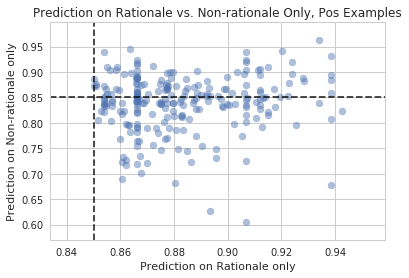

Number of "interesting" non-rationales, positive:  106


In [74]:
plt.scatter(rationale_only_preds_sis_pos, nonrationale_only_preds_sis_pos, alpha=0.45)
plt.axhline(y=pos_threshold, linestyle='--', color='black', alpha=0.8)
plt.axvline(x=pos_threshold, linestyle='--', color='black', alpha=0.8)
plt.xlabel('Prediction on Rationale only')
plt.ylabel('Prediction on Non-rationale only')
plt.title('Prediction on Rationale vs. Non-rationale Only, Pos Examples')
plt.show()

nonrationales_interesting_pos_idxs = pos_example_idxs[nonrationale_only_preds_sis_pos >= pos_threshold]
print('Number of "interesting" non-rationales, positive: ', len(nonrationales_interesting_pos_idxs))

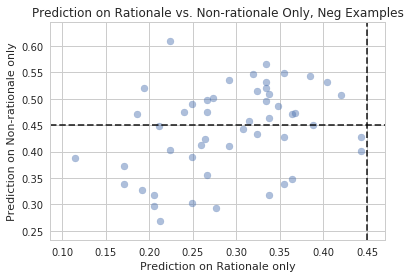

Number of "interesting" non-rationales, negative:  24


In [75]:
plt.scatter(rationale_only_preds_sis_neg, nonrationale_only_preds_sis_neg, alpha=0.45)
plt.axhline(y=neg_threshold, linestyle='--', color='black', alpha=0.8)
plt.axvline(x=neg_threshold, linestyle='--', color='black', alpha=0.8)
plt.xlabel('Prediction on Rationale only')
plt.ylabel('Prediction on Non-rationale only')
plt.title('Prediction on Rationale vs. Non-rationale Only, Neg Examples')
plt.show()

nonrationales_interesting_neg_idxs = neg_example_idxs[nonrationale_only_preds_sis_neg <= neg_threshold]
print('Number of "interesting" non-rationales, negative: ', len(nonrationales_interesting_neg_idxs))

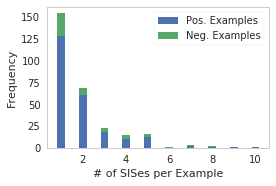

In [76]:
number_sufficient_rationales_pos = []
for review in brc.get_pos_reviews():
    num_rationales = len(review.get_rationales(SIS_RATIONALE_KEY))
    number_sufficient_rationales_pos.append(num_rationales)

number_sufficient_rationales_neg = []
for review in brc.get_neg_reviews():
    num_rationales = len(review.get_rationales(SIS_RATIONALE_KEY))
    number_sufficient_rationales_neg.append(num_rationales)

num_bins = max(np.max(number_sufficient_rationales_pos), np.max(number_sufficient_rationales_neg))
ind = np.arange(num_bins) + 1
pos_bincounts = np.bincount(number_sufficient_rationales_pos, minlength=num_bins+1)[1:]
neg_bincounts = np.bincount(number_sufficient_rationales_neg, minlength=num_bins+1)[1:]
width = 0.35

plt.figure(figsize=((4, 2.75)))
p_pos = plt.bar(ind, pos_bincounts, width)
p_neg = plt.bar(ind, neg_bincounts, width, bottom=pos_bincounts)
plt.legend((p_pos[0], p_neg[0]), ('Pos. Examples', 'Neg. Examples'), loc='upper right', frameon=True)
plt.xlabel('# of SISes per Example')
plt.ylabel('Frequency')
plt.grid(False)
#plt.title('Num. Sufficient Rationales for Necessary Rationale (Asp 1: Aroma)')
plt.tight_layout()
# plt.savefig(os.path.join(figures_dir, 'num_sufficient_rationales.png'), dpi=1200, bbox_inches='tight')
plt.show()

In [77]:
# Show all sufficient examples for some examples

max_sufficient_rationales_pos = 3  # np.max(number_sufficient_rationales_pos)

print('Max # of sufficient rationales: ', max_sufficient_rationales_pos)
print()

legend_html = visualizations.make_legend(max_sufficient_rationales_pos)
display(HTML(legend_html))

for review in brc.get_pos_reviews():
    num_rationales = len(review.get_rationales(SIS_RATIONALE_KEY))
    if num_rationales == max_sufficient_rationales_pos:
        print('i: ', review.i)
        rationales = review.get_rationales(SIS_RATIONALE_KEY)
        html = visualizations.highlight_multi_rationale(review, review.get_rationales(SIS_RATIONALE_KEY),
                                                        index_to_token)
        display(HTML(html))

Max # of sufficient rationales:  3



i:  249


i:  343


i:  350


i:  356


i:  513


i:  523


i:  555


i:  590


i:  601


i:  679


i:  810


i:  873


i:  904


i:  911


i:  927


i:  931


i:  965


i:  968


What if we compare the predictions on rationale only vs non-rationale only for the rationales produced by the perturbative baseline to results from sis method above?

Since the perturbation analysis shows that everything in the perturbative rationales matters but they tend to be longer, maybe finding some form of a necessary rationale (rather than sufficient produced by sis method).

In [78]:
# Positive examples, sis
rationale_only_preds_pert_pos = np.array([sis.predict_for_embed_sequence(
                                            [r.get_embedded_sequence_rationale_only(
                                                [r.get_rationales(PERTURB_SUFF_RATIONALE_KEY)[0]])],
                                            embed_model)[0] for r in brc.get_pos_reviews()])
nonrationale_only_preds_pert_pos = np.array([sis.predict_for_embed_sequence(
                                               [r.get_embedded_sequence_nonrationale_only(
                                                   [r.get_rationales(PERTURB_SUFF_RATIONALE_KEY)[0]])],
                                               embed_model)[0] for r in brc.get_pos_reviews()])

# # Negative examples, sis
rationale_only_preds_pert_neg = np.array([sis.predict_for_embed_sequence(
                                            [r.get_embedded_sequence_rationale_only(
                                                [r.get_rationales(PERTURB_SUFF_RATIONALE_KEY)[0]])],
                                            embed_model)[0] for r in brc.get_neg_reviews()])
nonrationale_only_preds_pert_neg = np.array([sis.predict_for_embed_sequence(
                                               [r.get_embedded_sequence_nonrationale_only(
                                                   [r.get_rationales(PERTURB_SUFF_RATIONALE_KEY)[0]])],
                                               embed_model)[0] for r in brc.get_neg_reviews()])

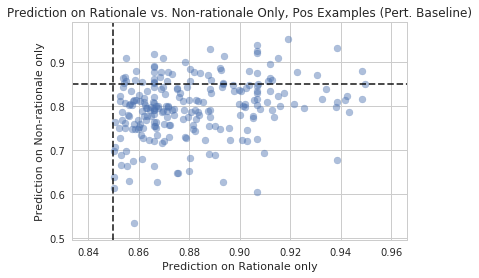

Number of "interesting" non-rationales, positive, perturbative baseline:  50


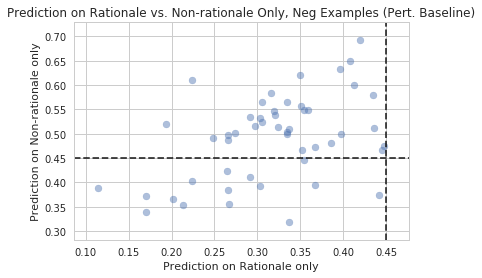

Number of "interesting" non-rationales, negative, perturbative baseline:  15


In [79]:
plt.scatter(rationale_only_preds_pert_pos, nonrationale_only_preds_pert_pos, alpha=0.45)
plt.axhline(y=pos_threshold, linestyle='--', color='black', alpha=0.8)
plt.axvline(x=pos_threshold, linestyle='--', color='black', alpha=0.8)
plt.xlabel('Prediction on Rationale only')
plt.ylabel('Prediction on Non-rationale only')
plt.title('Prediction on Rationale vs. Non-rationale Only, Pos Examples (Pert. Baseline)')
plt.show()

print('Number of "interesting" non-rationales, positive, perturbative baseline: ',
          len(pos_example_idxs[nonrationale_only_preds_pert_pos >= pos_threshold]))

plt.scatter(rationale_only_preds_pert_neg, nonrationale_only_preds_pert_neg, alpha=0.45)
plt.axhline(y=neg_threshold, linestyle='--', color='black', alpha=0.8)
plt.axvline(x=neg_threshold, linestyle='--', color='black', alpha=0.8)
plt.xlabel('Prediction on Rationale only')
plt.ylabel('Prediction on Non-rationale only')
plt.title('Prediction on Rationale vs. Non-rationale Only, Neg Examples (Pert. Baseline)')
plt.show()

print('Number of "interesting" non-rationales, negative, perturbative baseline: ',
          len(neg_example_idxs[nonrationale_only_preds_pert_neg <= neg_threshold]))

## Integrated Gradients

In [28]:
ig = integrated_gradients(embed_model)

Evaluated output channel (0-based index): All
Building gradient functions
Progress: 100.0%
Done.


/anaconda2/envs/py36/lib/python3.6/site-packages/keras/engine/sequential.py:109: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


In [29]:
igs_baseline = np.repeat(mean_embedding.reshape((1, mean_embedding.shape[0])), 500, axis=0)
print(igs_baseline.shape)

(500, 100)


## Dump HTML File with Highlighted Rationales

In [80]:
header = '''
<h2>Beer Review Aspect %d (Aroma) Sufficient Input Subsets</h2>
<p>Each color indices a sufficient input subset (SIS) such that prediction on that subset
    of words (all other words masked out) exceeds the threshold value
    (in positive examples, prediction >= %.2f, in negative examples, prediction <= %.2f).
    Underline indicates known human sentence-level annotations.
    The examples in this set were held-out during training.
    Highlight shade indicates word rank in the rationale, darker means more important,
    with linear scaling.</p>
''' % (ASPECT, pos_threshold, neg_threshold)

# Write all annotations to HTML outfile
html_outfile = '../html_rationales/asp%d_cnn_primary_sis.html' % ASPECT
html = ''
first_shown = False
for r in brc.get_all_reviews():
    sis_rationale = r.get_rationales(SIS_RATIONALE_KEY)[0]
    ig_rationale = r.get_rationales(IG_SUFF_RATIONALE_KEY)[0]
    lime_rationale = r.get_rationales(LIME_SUFF_RATIONALE_KEY)[0]
    pert_rationale = r.get_rationales(PERTURB_SUFF_RATIONALE_KEY)[0]
    html += '<p>Example %d</p>\n' % (r.i)
    html += '<p>Predicted: %.3f  /  Actual: %.3f<br>\n' % (r.original_prediction, annotations[r.i]['y'][ASPECT])
    html += 'Rationale length SIS = %d<br>\n' % len(sis_rationale)
    html += 'Rationale length Integrated Gradients = %d<br>\n' % len(ig_rationale)
    html += 'Rationale length LIME = %d<br>\n' % len(lime_rationale)
    html += 'Rationale length Perturbative Baseline = %d<br>\n' % len(pert_rationale)
    html += '<p>With SIS Method:</p>\n'
    html += visualizations.highlight_annot(r, sis_rationale, index_to_token, ASPECT)
    html += '\n<p>With Integrated Gradients:</p>\n'
    html += visualizations.highlight_annot(r, ig_rationale, index_to_token, ASPECT)
    html += '\n<p>With LIME:</p>\n'
    html += visualizations.highlight_annot(r, lime_rationale, index_to_token, ASPECT)
    html += '\n<p>With Perturbative Baseline:</p>\n'
    html += visualizations.highlight_annot(r, pert_rationale, index_to_token, ASPECT)
    html += '\n<hr>\n'
    if not first_shown:
        display(HTML(html))
        first_shown = True

# Dump HTML to file
visualizations.save_html(html, html_outfile, header)

In [81]:
# Highlight all rationales in single paragraph (colors no longer aspect-specific)

html_outfile = '../html_rationales/asp%d_cnn_multi_sis.html' % ASPECT
html = ''
first_shown = False
most_rationales = None
for r in brc.get_all_reviews():
    sis_rationales = r.get_rationales(SIS_RATIONALE_KEY)
    if most_rationales is None or len(sis_rationales) > most_rationales:
        most_rationales = len(sis_rationales)
    ig_rationale = r.get_rationales(IG_SUFF_RATIONALE_KEY)[0]
    lime_rationale = r.get_rationales(LIME_SUFF_RATIONALE_KEY)[0]
    pert_rationale = r.get_rationales(PERTURB_SUFF_RATIONALE_KEY)[0]
    html += '<p>Example %d</p>\n' % (r.i)
    # html += '<p>Predicted: %.3f  /  Actual: %.3f<br>\n' % (r.original_prediction, annotations[r.i]['y'][ASPECT])
    html += 'Rationale length SIS = %s<br>' % str([len(r) for r in sis_rationales])
    html += 'Rationale length Integrated Gradients = %d<br>\n' % len(ig_rationale)
    html += 'Rationale length LIME = %d<br>\n' % len(lime_rationale)
    html += 'Rationale length Perturbative Baseline = %d<br>\n' % len(pert_rationale)
    html += '\n<p><i>With SIS Method:</i></p>\n'
    html += visualizations.highlight_multi_rationale(r, sis_rationales, index_to_token)
    html += '\n<p><i>With Integrated Gradients:</i></p>\n'
    html += visualizations.highlight_multi_rationale(r, [ig_rationale], index_to_token)
    html += '\n<p><i>With LIME:</i></p>\n'
    html += visualizations.highlight_multi_rationale(r, [lime_rationale], index_to_token)
    html += '\n<p><i>With Perturbative Baseline:</i></p>\n'
    html += visualizations.highlight_multi_rationale(r, [pert_rationale], index_to_token)
    html += '\n<hr>\n'
    if not first_shown:
        display(HTML(html))
        first_shown = True

        
legend_html = visualizations.make_legend(most_rationales)

# Dump HTML to file
visualizations.save_html(html, html_outfile, header + legend_html + '<br>')

## History trends over time

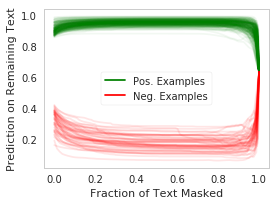

In [82]:
# SIS

pos_history_data = [(np.linspace(0, 1, len(hist)), np.array(hist)) for hist in \
                    (r.get_rationales(SIS_RATIONALE_KEY)[0].get_history()[1] \
                     for r in brc.get_pos_reviews())]

neg_history_data = [(np.linspace(0, 1, len(hist)), np.array(hist)) for hist in \
                    (r.get_rationales(SIS_RATIONALE_KEY)[0].get_history()[1] \
                     for r in brc.get_neg_reviews())]

plt.figure(figsize=(4, 3))
first = True
for x, y in pos_history_data:
    if first:
        label = 'Pos. Examples'
        first = False
    else:
        label = None
    plt.plot(x, y, alpha=0.05, c='g', label=label)
#plt.title('Predicted Scores during SIS Removal, Positive examples')
plt.xlabel('Fraction of Text Removed')
plt.ylabel('Prediction on Remaining Text')
plt.grid(False)

first = True
for x, y in neg_history_data:
    if first:
        label = 'Neg. Examples'
        first = False
    else:
        label = None
    plt.plot(x, y, alpha=0.1, c='r', label=label)
plt.xlabel('Fraction of Text Masked')
plt.ylabel('Prediction on Remaining Text')
plt.grid(False)
leg = plt.legend(loc='center', frameon=True)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.tight_layout()
# plt.savefig(os.path.join(figures_dir, 'history_trends.png'), dpi=1200, bbox_inches='tight')
plt.show()

## Perturbation analysis

For all the "interesting" examples, we remove each token one-at-a-time (replacing it with mean embedding) and predict for the sequence with that token missing. Then, see whether the words in the rationales (as found by sis method and IG) lead to bigger losses in predictive power with them removed.

In [83]:
## (Primary) SIS Rationales

# Positive reviews
rationale_diffs_sis_pos = []
nonrationale_diffs_sis_pos = []

for review in brc.get_pos_reviews():
    for r in review.get_rationales(SIS_RATIONALE_KEY):
        rationale_diffs, nonrationale_diffs = review.perturbation_rationale(
            embed_model,
            [r],
            diffs_transform_f=lambda preds_orig: preds_orig[1] - preds_orig[0])
        rationale_diffs_sis_pos.append(rationale_diffs)
        nonrationale_diffs_sis_pos.append(nonrationale_diffs)

rationale_diffs_sis_pos_vals = np.concatenate(rationale_diffs_sis_pos).ravel()
nonrationale_diffs_sis_pos_vals = np.concatenate(nonrationale_diffs_sis_pos).ravel()

# Negative reviews
rationale_diffs_sis_neg = []
nonrationale_diffs_sis_neg = []

for review in brc.get_neg_reviews():
    for r in review.get_rationales(SIS_RATIONALE_KEY):
        rationale_diffs, nonrationale_diffs = review.perturbation_rationale(
            embed_model,
            [r],
            diffs_transform_f=lambda preds_orig: preds_orig[0] - preds_orig[1])
        rationale_diffs_sis_neg.append(rationale_diffs)
        nonrationale_diffs_sis_neg.append(nonrationale_diffs)
    
rationale_diffs_sis_neg_vals = np.concatenate(rationale_diffs_sis_neg).ravel()
nonrationale_diffs_sis_neg_vals = np.concatenate(nonrationale_diffs_sis_neg).ravel()

/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


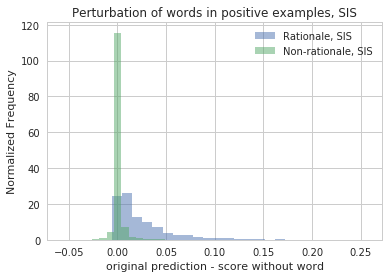

/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


RanksumsResult(statistic=42.419600019894375, pvalue=0.0)


/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


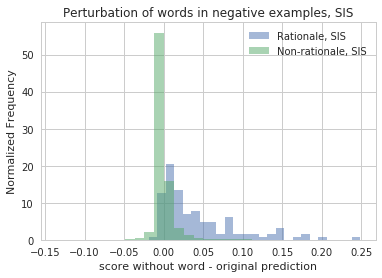

RanksumsResult(statistic=14.959050492954203, pvalue=1.3595190794117417e-50)


In [84]:
plt.hist(rationale_diffs_sis_pos_vals, normed=True, alpha=0.5, bins=25, label='Rationale, SIS')
plt.hist(nonrationale_diffs_sis_pos_vals, normed=True, alpha=0.5, bins=25, label='Non-rationale, SIS')
plt.legend(loc='upper right')
plt.xlabel('original prediction - score without word')
plt.ylabel('Normalized Frequency')
plt.title('Perturbation of words in positive examples, SIS')
plt.show()

# Compare the two distributions using ranksum test
print(ranksums(rationale_diffs_sis_pos_vals, nonrationale_diffs_sis_pos_vals))

plt.hist(rationale_diffs_sis_neg_vals, normed=True, alpha=0.5, bins=25, label='Rationale, SIS')
plt.hist(nonrationale_diffs_sis_neg_vals, normed=True, alpha=0.5, bins=25, label='Non-rationale, SIS')
plt.legend(loc='upper right')
plt.xlabel('score without word - original prediction')
plt.ylabel('Normalized Frequency')
plt.title('Perturbation of words in negative examples, SIS')
plt.show()

print(ranksums(rationale_diffs_sis_neg_vals, nonrationale_diffs_sis_neg_vals))

In [85]:
## Integrated Gradients Rationales

# Positive reviews
rationale_diffs_ig_pos = []
nonrationale_diffs_ig_pos = []

for r in brc.get_pos_reviews():
    rationale_diffs, nonrationale_diffs = r.perturbation_rationale(
        embed_model,
        [r.get_rationales(IG_SUFF_RATIONALE_KEY)[0]],
        diffs_transform_f=lambda preds_orig: preds_orig[1] - preds_orig[0])
    rationale_diffs_ig_pos.append(rationale_diffs)
    nonrationale_diffs_ig_pos.append(nonrationale_diffs)

rationale_diffs_ig_pos_vals = np.concatenate(rationale_diffs_ig_pos).ravel()
nonrationale_diffs_ig_pos_vals = np.concatenate(nonrationale_diffs_ig_pos).ravel()

# Negative reviews
rationale_diffs_ig_neg = []
nonrationale_diffs_ig_neg = []

for r in brc.get_neg_reviews():
    rationale_diffs, nonrationale_diffs = r.perturbation_rationale(
        embed_model,
        [r.get_rationales(IG_SUFF_RATIONALE_KEY)[0]],
        diffs_transform_f=lambda preds_orig: preds_orig[0] - preds_orig[1])
    rationale_diffs_ig_neg.append(rationale_diffs)
    nonrationale_diffs_ig_neg.append(nonrationale_diffs)
    
rationale_diffs_ig_neg_vals = np.concatenate(rationale_diffs_ig_neg).ravel()
nonrationale_diffs_ig_neg_vals = np.concatenate(nonrationale_diffs_ig_neg).ravel()

/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


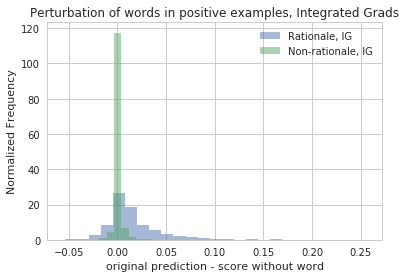

/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


RanksumsResult(statistic=34.12315094284834, pvalue=3.346313112633145e-255)


/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


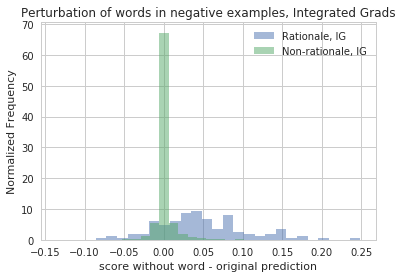

RanksumsResult(statistic=10.329151463026404, pvalue=5.201869759880261e-25)


In [86]:
plt.hist(rationale_diffs_ig_pos_vals, normed=True, alpha=0.5, bins=25, label='Rationale, IG')
plt.hist(nonrationale_diffs_ig_pos_vals, normed=True, alpha=0.5, bins=25, label='Non-rationale, IG')
plt.legend(loc='upper right')
plt.xlabel('original prediction - score without word')
plt.ylabel('Normalized Frequency')
plt.title('Perturbation of words in positive examples, Integrated Grads')
plt.show()

# Compare the two distributions using ranksum test
print(ranksums(rationale_diffs_ig_pos_vals, nonrationale_diffs_ig_pos_vals))

plt.hist(rationale_diffs_ig_neg_vals, normed=True, alpha=0.5, bins=25, label='Rationale, IG')
plt.hist(nonrationale_diffs_ig_neg_vals, normed=True, alpha=0.5, bins=25, label='Non-rationale, IG')
plt.legend(loc='upper right')
plt.xlabel('score without word - original prediction')
plt.ylabel('Normalized Frequency')
plt.title('Perturbation of words in negative examples, Integrated Grads')
plt.show()

print(ranksums(rationale_diffs_ig_neg_vals, nonrationale_diffs_ig_neg_vals))

In [87]:
## LIME Rationales

# Positive reviews
rationale_diffs_lime_pos = []
nonrationale_diffs_lime_pos = []

for r in brc.get_pos_reviews():
    rationale_diffs, nonrationale_diffs = r.perturbation_rationale(
        embed_model,
        [r.get_rationales(LIME_SUFF_RATIONALE_KEY)[0]],
        diffs_transform_f=lambda preds_orig: preds_orig[1] - preds_orig[0])
    rationale_diffs_lime_pos.append(rationale_diffs)
    nonrationale_diffs_lime_pos.append(nonrationale_diffs)

rationale_diffs_lime_pos_vals = np.concatenate(rationale_diffs_lime_pos).ravel()
nonrationale_diffs_lime_pos_vals = np.concatenate(nonrationale_diffs_lime_pos).ravel()

# Negative reviews
rationale_diffs_lime_neg = []
nonrationale_diffs_lime_neg = []

for r in brc.get_neg_reviews():
    rationale_diffs, nonrationale_diffs = r.perturbation_rationale(
        embed_model,
        [r.get_rationales(LIME_SUFF_RATIONALE_KEY)[0]],
        diffs_transform_f=lambda preds_orig: preds_orig[0] - preds_orig[1])
    rationale_diffs_lime_neg.append(rationale_diffs)
    nonrationale_diffs_lime_neg.append(nonrationale_diffs)
    
rationale_diffs_lime_neg_vals = np.concatenate(rationale_diffs_lime_neg).ravel()
nonrationale_diffs_lime_neg_vals = np.concatenate(nonrationale_diffs_lime_neg).ravel()

/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


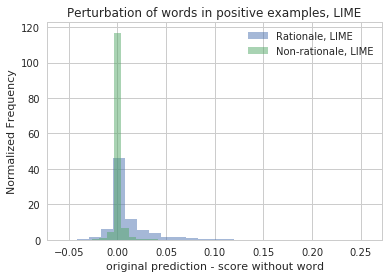

/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


RanksumsResult(statistic=26.55735684784088, pvalue=2.11187679230583e-155)


/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


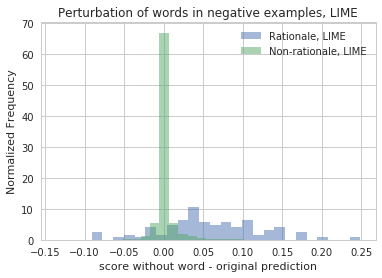

RanksumsResult(statistic=11.136920954304218, pvalue=8.293733797519754e-29)


In [88]:
plt.hist(rationale_diffs_lime_pos_vals, normed=True, alpha=0.5, bins=25, label='Rationale, LIME')
plt.hist(nonrationale_diffs_lime_pos_vals, normed=True, alpha=0.5, bins=25, label='Non-rationale, LIME')
plt.legend(loc='upper right')
plt.xlabel('original prediction - score without word')
plt.ylabel('Normalized Frequency')
plt.title('Perturbation of words in positive examples, LIME')
plt.show()

# Compare the two distributions using ranksum test
print(ranksums(rationale_diffs_lime_pos_vals, nonrationale_diffs_lime_pos_vals))

plt.hist(rationale_diffs_lime_neg_vals, normed=True, alpha=0.5, bins=25, label='Rationale, LIME')
plt.hist(nonrationale_diffs_lime_neg_vals, normed=True, alpha=0.5, bins=25, label='Non-rationale, LIME')
plt.legend(loc='upper right')
plt.xlabel('score without word - original prediction')
plt.ylabel('Normalized Frequency')
plt.title('Perturbation of words in negative examples, LIME')
plt.show()

print(ranksums(rationale_diffs_lime_neg_vals, nonrationale_diffs_lime_neg_vals))

In [89]:
## Perturbative Baseline Rationales

# Positive reviews
rationale_diffs_pert_pos = []
nonrationale_diffs_pert_pos = []

for r in brc.get_pos_reviews():
    rationale_diffs, nonrationale_diffs = r.perturbation_rationale(
        embed_model,
        [r.get_rationales(PERTURB_SUFF_RATIONALE_KEY)[0]],
        diffs_transform_f=lambda preds_orig: preds_orig[1] - preds_orig[0])
    rationale_diffs_pert_pos.append(rationale_diffs)
    nonrationale_diffs_pert_pos.append(nonrationale_diffs)

rationale_diffs_pert_pos_vals = np.concatenate(rationale_diffs_pert_pos).ravel()
nonrationale_diffs_pert_pos_vals = np.concatenate(nonrationale_diffs_pert_pos).ravel()

# Negative reviews
rationale_diffs_pert_neg = []
nonrationale_diffs_pert_neg = []

for r in brc.get_neg_reviews():
    rationale_diffs, nonrationale_diffs = r.perturbation_rationale(
        embed_model,
        [r.get_rationales(PERTURB_SUFF_RATIONALE_KEY)[0]],
        diffs_transform_f=lambda preds_orig: preds_orig[0] - preds_orig[1])
    rationale_diffs_pert_neg.append(rationale_diffs)
    nonrationale_diffs_pert_neg.append(nonrationale_diffs)
    
rationale_diffs_pert_neg_vals = np.concatenate(rationale_diffs_pert_neg).ravel()
nonrationale_diffs_pert_neg_vals = np.concatenate(nonrationale_diffs_pert_neg).ravel()

/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


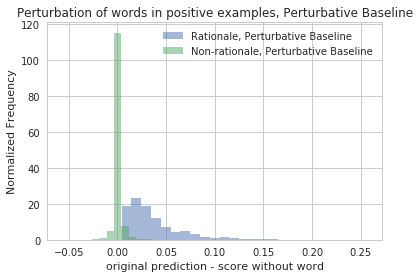

RanksumsResult(statistic=46.19797771292033, pvalue=0.0)


/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


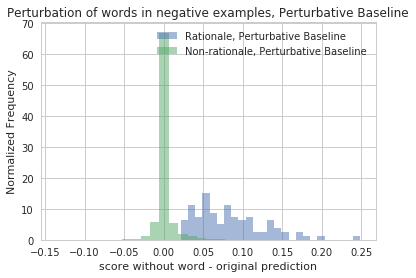

RanksumsResult(statistic=15.912372535120971, pvalue=5.200480424002054e-57)


In [90]:
plt.hist(rationale_diffs_pert_pos_vals, normed=True, alpha=0.5, bins=25, label='Rationale, Perturbative Baseline')
plt.hist(nonrationale_diffs_pert_pos_vals, normed=True, alpha=0.5, bins=25, label='Non-rationale, Perturbative Baseline')
plt.legend(loc='upper right')
plt.xlabel('original prediction - score without word')
plt.ylabel('Normalized Frequency')
plt.title('Perturbation of words in positive examples, Perturbative Baseline')
plt.show()

# Compare the two distributions using ranksum test
print(ranksums(rationale_diffs_pert_pos_vals, nonrationale_diffs_pert_pos_vals))

plt.hist(rationale_diffs_pert_neg_vals, normed=True, alpha=0.5, bins=25, label='Rationale, Perturbative Baseline')
plt.hist(nonrationale_diffs_pert_neg_vals, normed=True, alpha=0.5, bins=25, label='Non-rationale, Perturbative Baseline')
plt.legend(loc='upper right')
plt.xlabel('score without word - original prediction')
plt.ylabel('Normalized Frequency')
plt.title('Perturbation of words in negative examples, Perturbative Baseline')
plt.show()

print(ranksums(rationale_diffs_pert_neg_vals, nonrationale_diffs_pert_neg_vals))

/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


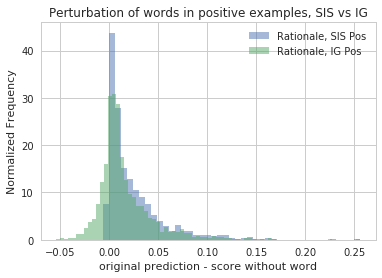

RanksumsResult(statistic=8.09685504762567, pvalue=5.63982061304129e-16)


/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


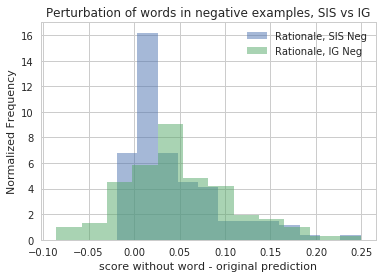

RanksumsResult(statistic=-1.1184814017043954, pvalue=0.26336144536637573)


In [91]:
# Compare rationales-only to rationales-only

plt.hist(rationale_diffs_sis_pos_vals, normed=True, alpha=0.5, bins='auto', label='Rationale, SIS Pos')
plt.hist(rationale_diffs_ig_pos_vals, normed=True, alpha=0.5, bins='auto', label='Rationale, IG Pos')
plt.legend(loc='upper right')
plt.xlabel('original prediction - score without word')
plt.ylabel('Normalized Frequency')
plt.title('Perturbation of words in positive examples, SIS vs IG')
plt.show()

print(ranksums(rationale_diffs_sis_pos_vals, rationale_diffs_ig_pos_vals))

plt.hist(rationale_diffs_sis_neg_vals, normed=True, alpha=0.5, bins='auto', label='Rationale, SIS Neg')
plt.hist(rationale_diffs_ig_neg_vals, normed=True, alpha=0.5, bins='auto', label='Rationale, IG Neg')
plt.legend(loc='upper right')
plt.xlabel('score without word - original prediction')
plt.ylabel('Normalized Frequency')
plt.title('Perturbation of words in negative examples, SIS vs IG')
plt.show()

print(ranksums(rationale_diffs_sis_neg_vals, rationale_diffs_ig_neg_vals))

/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


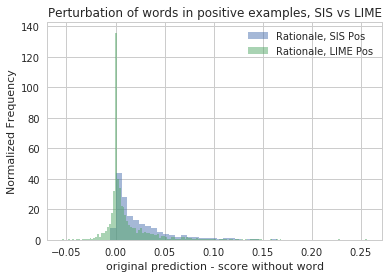

RanksumsResult(statistic=18.993508782525343, pvalue=1.9299186434420608e-80)


/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


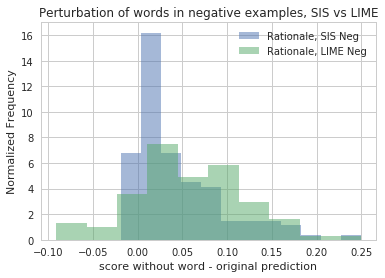

RanksumsResult(statistic=-2.7337229736238102, pvalue=0.0062622707105987096)


In [92]:
plt.hist(rationale_diffs_sis_pos_vals, normed=True, alpha=0.5, bins='auto', label='Rationale, SIS Pos')
plt.hist(rationale_diffs_lime_pos_vals, normed=True, alpha=0.5, bins='auto', label='Rationale, LIME Pos')
plt.legend(loc='upper right')
plt.xlabel('original prediction - score without word')
plt.ylabel('Normalized Frequency')
plt.title('Perturbation of words in positive examples, SIS vs LIME')
plt.show()

print(ranksums(rationale_diffs_sis_pos_vals, rationale_diffs_lime_pos_vals))

plt.hist(rationale_diffs_sis_neg_vals, normed=True, alpha=0.5, bins='auto', label='Rationale, SIS Neg')
plt.hist(rationale_diffs_lime_neg_vals, normed=True, alpha=0.5, bins='auto', label='Rationale, LIME Neg')
plt.legend(loc='upper right')
plt.xlabel('score without word - original prediction')
plt.ylabel('Normalized Frequency')
plt.title('Perturbation of words in negative examples, SIS vs LIME')
plt.show()

print(ranksums(rationale_diffs_sis_neg_vals, rationale_diffs_lime_neg_vals))

/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


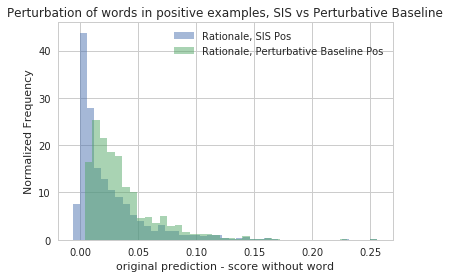

RanksumsResult(statistic=-13.493437960832345, pvalue=1.7093977381375153e-41)


/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


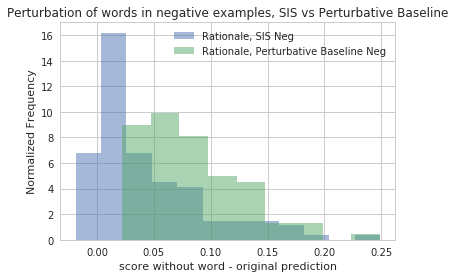

RanksumsResult(statistic=-6.643658460499022, pvalue=3.0599117205562955e-11)


In [93]:
plt.hist(rationale_diffs_sis_pos_vals, normed=True, alpha=0.5, bins='auto', label='Rationale, SIS Pos')
plt.hist(rationale_diffs_pert_pos_vals, normed=True, alpha=0.5, bins='auto', label='Rationale, Perturbative Baseline Pos')
plt.legend(loc='upper right')
plt.xlabel('original prediction - score without word')
plt.ylabel('Normalized Frequency')
plt.title('Perturbation of words in positive examples, SIS vs Perturbative Baseline')
plt.show()

print(ranksums(rationale_diffs_sis_pos_vals, rationale_diffs_pert_pos_vals))

plt.hist(rationale_diffs_sis_neg_vals, normed=True, alpha=0.5, bins='auto', label='Rationale, SIS Neg')
plt.hist(rationale_diffs_pert_neg_vals, normed=True, alpha=0.5, bins='auto', label='Rationale, Perturbative Baseline Neg')
plt.legend(loc='upper right')
plt.xlabel('score without word - original prediction')
plt.ylabel('Normalized Frequency')
plt.title('Perturbation of words in negative examples, SIS vs Perturbative Baseline')
plt.show()

print(ranksums(rationale_diffs_sis_neg_vals, rationale_diffs_pert_neg_vals))

In [94]:
## Fixed Length IG Baseline Rationales

# Positive reviews
rationale_diffs_fixed_length_ig_pos = []
nonrationale_diffs_fixed_length_ig_pos = []

for r in brc.get_pos_reviews():
    rationale_diffs, nonrationale_diffs = r.perturbation_rationale(
        embed_model,
        [r.get_rationales(IG_FIXED_RATIONALE_KEY)[0]],
        diffs_transform_f=lambda preds_orig: preds_orig[1] - preds_orig[0])
    rationale_diffs_fixed_length_ig_pos.append(rationale_diffs)
    nonrationale_diffs_fixed_length_ig_pos.append(nonrationale_diffs)

rationale_diffs_fixed_length_ig_pos_vals = np.concatenate(rationale_diffs_fixed_length_ig_pos).ravel()
nonrationale_diffs_fixed_length_ig_pos_vals = np.concatenate(nonrationale_diffs_fixed_length_ig_pos).ravel()

# Negative reviews
rationale_diffs_fixed_length_ig_neg = []
nonrationale_diffs_fixed_length_ig_neg = []

for r in brc.get_neg_reviews():
    rationale_diffs, nonrationale_diffs = r.perturbation_rationale(
        embed_model,
        [r.get_rationales(IG_FIXED_RATIONALE_KEY)[0]],
        diffs_transform_f=lambda preds_orig: preds_orig[0] - preds_orig[1])
    rationale_diffs_fixed_length_ig_neg.append(rationale_diffs)
    nonrationale_diffs_fixed_length_ig_neg.append(nonrationale_diffs)
    
rationale_diffs_fixed_length_ig_neg_vals = np.concatenate(rationale_diffs_fixed_length_ig_neg).ravel()
nonrationale_diffs_fixed_length_ig_neg_vals = np.concatenate(nonrationale_diffs_fixed_length_ig_neg).ravel()

In [95]:
## Fixed Length LIME Baseline Rationales

# Positive reviews
rationale_diffs_fixed_length_lime_pos = []
nonrationale_diffs_fixed_length_lime_pos = []

for r in brc.get_pos_reviews():
    rationale_diffs, nonrationale_diffs = r.perturbation_rationale(
        embed_model,
        [r.get_rationales(LIME_FIXED_RATIONALE_KEY)[0]],
        diffs_transform_f=lambda preds_orig: preds_orig[1] - preds_orig[0])
    rationale_diffs_fixed_length_lime_pos.append(rationale_diffs)
    nonrationale_diffs_fixed_length_lime_pos.append(nonrationale_diffs)

rationale_diffs_fixed_length_lime_pos_vals = np.concatenate(rationale_diffs_fixed_length_lime_pos).ravel()
nonrationale_diffs_fixed_length_lime_pos_vals = np.concatenate(nonrationale_diffs_fixed_length_lime_pos).ravel()

# Negative reviews
rationale_diffs_fixed_length_lime_neg = []
nonrationale_diffs_fixed_length_lime_neg = []

for r in brc.get_neg_reviews():
    rationale_diffs, nonrationale_diffs = r.perturbation_rationale(
        embed_model,
        [r.get_rationales(LIME_FIXED_RATIONALE_KEY)[0]],
        diffs_transform_f=lambda preds_orig: preds_orig[0] - preds_orig[1])
    rationale_diffs_fixed_length_lime_neg.append(rationale_diffs)
    nonrationale_diffs_fixed_length_lime_neg.append(nonrationale_diffs)
    
rationale_diffs_fixed_length_lime_neg_vals = np.concatenate(rationale_diffs_fixed_length_lime_neg).ravel()
nonrationale_diffs_fixed_length_lime_neg_vals = np.concatenate(nonrationale_diffs_fixed_length_lime_neg).ravel()

In [96]:
## Fixed Length Perturbative Baseline Rationales

# Positive reviews
rationale_diffs_fixed_length_pert_pos = []
nonrationale_diffs_fixed_length_pert_pos = []

for r in brc.get_pos_reviews():
    rationale_diffs, nonrationale_diffs = r.perturbation_rationale(
        embed_model,
        [r.get_rationales(PERTURB_FIXED_RATIONALE_KEY)[0]],
        diffs_transform_f=lambda preds_orig: preds_orig[1] - preds_orig[0])
    rationale_diffs_fixed_length_pert_pos.append(rationale_diffs)
    nonrationale_diffs_fixed_length_pert_pos.append(nonrationale_diffs)

rationale_diffs_fixed_length_pert_pos_vals = np.concatenate(rationale_diffs_fixed_length_pert_pos).ravel()
nonrationale_diffs_fixed_length_pert_pos_vals = np.concatenate(nonrationale_diffs_fixed_length_pert_pos).ravel()

# Negative reviews
rationale_diffs_fixed_length_pert_neg = []
nonrationale_diffs_fixed_length_pert_neg = []

for r in brc.get_neg_reviews():
    rationale_diffs, nonrationale_diffs = r.perturbation_rationale(
        embed_model,
        [r.get_rationales(PERTURB_FIXED_RATIONALE_KEY)[0]],
        diffs_transform_f=lambda preds_orig: preds_orig[0] - preds_orig[1])
    rationale_diffs_fixed_length_pert_neg.append(rationale_diffs)
    nonrationale_diffs_fixed_length_pert_neg.append(nonrationale_diffs)
    
rationale_diffs_fixed_length_pert_neg_vals = np.concatenate(rationale_diffs_fixed_length_pert_neg).ravel()
nonrationale_diffs_fixed_length_pert_neg_vals = np.concatenate(nonrationale_diffs_fixed_length_pert_neg).ravel()

In [97]:
# Merge results from positive and negative examples
rationale_diffs_sis_all_vals = np.concatenate((rationale_diffs_sis_pos_vals, rationale_diffs_sis_neg_vals))
rationale_diffs_ig_all_vals = np.concatenate((rationale_diffs_ig_pos_vals, rationale_diffs_ig_neg_vals))
rationale_diffs_lime_all_vals = np.concatenate((rationale_diffs_lime_pos_vals, rationale_diffs_lime_neg_vals))
rationale_diffs_pert_all_vals = np.concatenate((rationale_diffs_pert_pos_vals, rationale_diffs_pert_neg_vals))
rationale_diffs_fixed_length_ig_all_vals = np.concatenate((rationale_diffs_fixed_length_ig_pos_vals, rationale_diffs_fixed_length_ig_neg_vals))
rationale_diffs_fixed_length_lime_all_vals = np.concatenate((rationale_diffs_fixed_length_lime_pos_vals, rationale_diffs_fixed_length_lime_neg_vals))
rationale_diffs_fixed_length_pert_all_vals = np.concatenate((rationale_diffs_fixed_length_pert_pos_vals, rationale_diffs_fixed_length_pert_neg_vals))

nonrationale_diffs_sis_all_vals = np.concatenate((nonrationale_diffs_sis_pos_vals, nonrationale_diffs_sis_neg_vals))
nonrationale_diffs_ig_all_vals = np.concatenate((nonrationale_diffs_ig_pos_vals, nonrationale_diffs_ig_neg_vals))
nonrationale_diffs_lime_all_vals = np.concatenate((nonrationale_diffs_lime_pos_vals, nonrationale_diffs_lime_neg_vals))
nonrationale_diffs_pert_all_vals = np.concatenate((nonrationale_diffs_pert_pos_vals, nonrationale_diffs_pert_neg_vals))
nonrationale_diffs_fixed_length_ig_all_vals = np.concatenate((nonrationale_diffs_fixed_length_ig_pos_vals, nonrationale_diffs_fixed_length_ig_neg_vals))
nonrationale_diffs_fixed_length_lime_all_vals = np.concatenate((nonrationale_diffs_fixed_length_lime_pos_vals, nonrationale_diffs_fixed_length_lime_neg_vals))
nonrationale_diffs_fixed_length_pert_all_vals = np.concatenate((nonrationale_diffs_fixed_length_pert_pos_vals, nonrationale_diffs_fixed_length_pert_neg_vals))


# Create DataFrame
columns = ['method', 'rationale_nonrationale', 'perturbation_delta']

sis_rationale_df = pd.DataFrame([('SIS', 'Rationale', p) for p in rationale_diffs_sis_all_vals],
                                   columns=columns)
sis_nonrationale_df = pd.DataFrame([('SIS', 'Other text', p) for p in nonrationale_diffs_sis_all_vals],
                                   columns=columns)

ig_rationale_df = pd.DataFrame([('Suff. IG', 'Rationale', p) for p in rationale_diffs_ig_all_vals],
                                   columns=columns)
ig_nonrationale_df = pd.DataFrame([('Suff. IG', 'Other text', p) for p in nonrationale_diffs_ig_all_vals],
                                   columns=columns)

lime_rationale_df = pd.DataFrame([('Suff. LIME', 'Rationale', p) for p in rationale_diffs_lime_all_vals],
                                   columns=columns)
lime_nonrationale_df = pd.DataFrame([('Suff. LIME', 'Other text', p) for p in nonrationale_diffs_lime_all_vals],
                                   columns=columns)

pert_rationale_df = pd.DataFrame([('Suff. Perturb.', 'Rationale', p) for p in rationale_diffs_pert_all_vals],
                                   columns=columns)
pert_nonrationale_df = pd.DataFrame([('Suff. Perturb.', 'Other text', p) for p in nonrationale_diffs_pert_all_vals],
                                   columns=columns)

fixed_length_ig_rationale_df = pd.DataFrame([('IG', 'Rationale', p) for p in rationale_diffs_fixed_length_ig_all_vals],
                                   columns=columns)
fixed_length_ig_nonrationale_df = pd.DataFrame([('IG', 'Other text', p) for p in nonrationale_diffs_fixed_length_ig_all_vals],
                                   columns=columns)

fixed_length_lime_rationale_df = pd.DataFrame([('LIME', 'Rationale', p) for p in rationale_diffs_fixed_length_lime_all_vals],
                                   columns=columns)
fixed_length_lime_nonrationale_df = pd.DataFrame([('LIME', 'Other text', p) for p in nonrationale_diffs_fixed_length_lime_all_vals],
                                   columns=columns)

fixed_length_pert_rationale_df = pd.DataFrame([('Perturb.', 'Rationale', p) for p in rationale_diffs_fixed_length_pert_all_vals],
                                   columns=columns)
fixed_length_pert_nonrationale_df = pd.DataFrame([('Perturb.', 'Other text', p) for p in nonrationale_diffs_fixed_length_pert_all_vals],
                                   columns=columns)

perturbation_df = pd.concat([sis_rationale_df, sis_nonrationale_df,
                             ig_rationale_df, ig_nonrationale_df,
                             lime_rationale_df, lime_nonrationale_df,
                             pert_rationale_df, pert_nonrationale_df],
#                              fixed_length_ig_rationale_df, fixed_length_ig_nonrationale_df,
#                              fixed_length_lime_rationale_df, fixed_length_lime_nonrationale_df,
#                              fixed_length_pert_rationale_df, fixed_length_pert_nonrationale_df],
                            ignore_index=True)

In [98]:
# Statistical analysis
print('Median SIS R: ', np.median(rationale_diffs_sis_all_vals))
print('Median SIS NR: ', np.median(nonrationale_diffs_sis_all_vals))
print('Median IG R: ', np.median(rationale_diffs_ig_all_vals))
print('Median IG NR: ', np.median(nonrationale_diffs_ig_all_vals))
print('Median LIME R: ', np.median(rationale_diffs_lime_all_vals))
print('Median LIME NR: ', np.median(nonrationale_diffs_lime_all_vals))
print('Median Perturb R: ', np.median(rationale_diffs_pert_all_vals))
print('Median Perturb NR: ', np.median(nonrationale_diffs_pert_all_vals))
print()
print('SIS R vs. NR: ', ranksums(rationale_diffs_sis_all_vals, nonrationale_diffs_sis_all_vals))
print('IG R vs. NR: ', ranksums(rationale_diffs_ig_all_vals, nonrationale_diffs_ig_all_vals))
print('LIME R vs. NR: ', ranksums(rationale_diffs_lime_all_vals, nonrationale_diffs_lime_all_vals))
print('Perturb R vs. NR: ', ranksums(rationale_diffs_pert_all_vals, nonrationale_diffs_pert_all_vals))
print()
print('SIS R vs. IG R: ', ranksums(rationale_diffs_sis_all_vals, rationale_diffs_ig_all_vals))
print('SIS R vs. LIME R: ', ranksums(rationale_diffs_sis_all_vals, rationale_diffs_lime_all_vals))
print('SIS R vs. Perturb R: ', ranksums(rationale_diffs_sis_all_vals, rationale_diffs_pert_all_vals))

Median SIS R:  0.014341593
Median SIS NR:  0.0
Median IG R:  0.00915736
Median IG NR:  0.0
Median LIME R:  0.002385199
Median LIME NR:  0.0
Median Perturb R:  0.031149864
Median Perturb NR:  0.0

SIS R vs. NR:  RanksumsResult(statistic=44.60982382638997, pvalue=0.0)
IG R vs. NR:  RanksumsResult(statistic=35.22480300505988, pvalue=8.343024336970205e-272)
LIME R vs. NR:  RanksumsResult(statistic=27.940071407104575, pvalue=8.703373460711851e-172)
Perturb R vs. NR:  RanksumsResult(statistic=48.56134672264897, pvalue=0.0)

SIS R vs. IG R:  RanksumsResult(statistic=8.142154577772974, pvalue=3.8830505626675264e-16)
SIS R vs. LIME R:  RanksumsResult(statistic=19.196733592738326, pvalue=3.941102036162342e-82)
SIS R vs. Perturb R:  RanksumsResult(statistic=-14.57651243782317, pvalue=3.9624870845377745e-48)


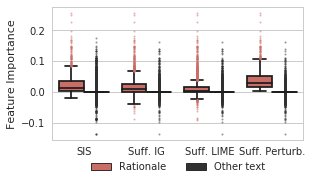

In [99]:
# https://stackoverflow.com/questions/36874697/how-to-edit-properties-of-whiskers-fliers-caps-etc-in-seaborn-boxplot
#   for boxplot drawing

plt.figure(figsize=(4.5, 2.75))
ax = sns.boxplot(x='method', y='perturbation_delta', hue='rationale_nonrationale',
            data=perturbation_df, orient='v',
            palette=sns.color_palette([sns.color_palette('hls', 8)[0], sns.light_palette('black', reverse=True)[1]]),
            flierprops={'markersize': 2, 'marker': 'o', 'alpha': 0.5})
for i, artist in enumerate(ax.artists):
    col = artist.get_facecolor()
    for j in range(i*6, i*6+6):
        line = ax.lines[j]
        line.set_mfc(col)
        line.set_mec(col)
plt.xlabel('')
plt.ylabel('Feature Importance')
plt.legend(loc='center', title=None, frameon=False, ncol=2, bbox_to_anchor=(0.5, -0.2))
plt.tight_layout()
# plt.savefig(os.path.join(figures_dir, 'perturbation_boxplot.png'), dpi=1200, bbox_inches='tight')
plt.show()

In [100]:
# Dump table rows for paper

rats_baseline = rationale_diffs_sis_all_vals
float_formatter = '%.4f'
exp_formatter = '%.2e'

for title, rat_vals, other_vals in [('SIS', rationale_diffs_sis_all_vals, nonrationale_diffs_sis_all_vals),
                    ('Suff. IG', rationale_diffs_ig_all_vals, nonrationale_diffs_ig_all_vals),
                    ('Suff. LIME', rationale_diffs_lime_all_vals, nonrationale_diffs_lime_all_vals),
                    ('Suff. Perturb.', rationale_diffs_pert_all_vals, nonrationale_diffs_pert_all_vals)]:
    median_rationales = float_formatter % np.median(rat_vals)
    median_other = exp_formatter % np.median(other_vals)
    _, p_rat = ranksums(rats_baseline, rat_vals)
    if p_rat == 1:
        p_rat = '--'
    else:
        p_rat = '%.0e' % p_rat
    data = [median_rationales, median_other, p_rat]
    tex = ' & '.join(data)
    tex += '  \\\\'
    print(tex)

0.0143 & 0.00e+00 & --  \\
0.0092 & 0.00e+00 & 4e-16  \\
0.0024 & 0.00e+00 & 4e-82  \\
0.0311 & 0.00e+00 & 4e-48  \\


# Rationale-only Prediction vs. Rationale Length

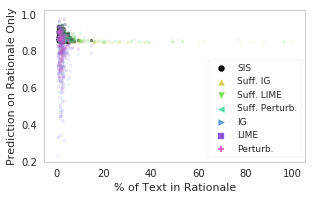

In [101]:
keys = [(SIS_RATIONALE_KEY, 'SIS'), (IG_SUFF_RATIONALE_KEY, 'Suff. IG'), (LIME_SUFF_RATIONALE_KEY, 'Suff. LIME'),
        (PERTURB_SUFF_RATIONALE_KEY, 'Suff. Perturb.'), (IG_FIXED_RATIONALE_KEY, 'IG'),
        (LIME_FIXED_RATIONALE_KEY, 'LIME'), (PERTURB_FIXED_RATIONALE_KEY, 'Perturb.')]

markers = ['o', '^', 'v', '<', '>', 's', '+']

#plt.figure(figsize=(4.25, 3.0))
plt.figure(figsize=(4.5, 2.9))
for i, (rationale_key, label) in enumerate(keys):
    x_rationale_only = []
    rationale_lens_percentage = []
    for review in brc.get_pos_reviews():
        rationales = review.get_rationales(rationale_key)
        for rationale in rationales:
            x_rationale_only.append(review.get_embedded_sequence_rationale_only([rationale]))
            rationale_lens_percentage.append(len(rationale) / float(review.get_num_tokens()) * 100.0)
    rationale_only_preds = sis.predict_for_embed_sequence(x_rationale_only, embed_model)
    rationale_lens_percentage = np.array(rationale_lens_percentage)
    assert(rationale_only_preds.shape == rationale_lens_percentage.shape)

    if i == 0:
        color = 'black'
        alpha = 0.5
    else:
        color = sns.color_palette('hls', 7)[i]
        alpha = 0.10
    marker = markers[i]

    plt.scatter(rationale_lens_percentage, rationale_only_preds, c=color, alpha=alpha, s=9, label=label, marker=marker)

plt.xlabel('% of Text in Rationale')
plt.ylabel('Prediction on Rationale Only')
plt.grid(False)
leg = plt.legend(loc='lower right', frameon=True, markerscale=2, fontsize=9)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.tight_layout()
# plt.savefig(os.path.join(figures_dir, 'rationale_prediction_vs_length_pos.png'), dpi=1200, bbox_inches='tight')
plt.show()

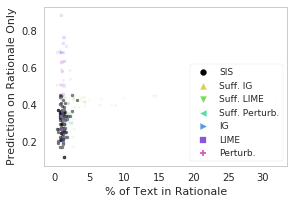

In [102]:
plt.figure(figsize=(4.25, 3.0))
for i, (rationale_key, label) in enumerate(keys):
    x_rationale_only = []
    rationale_lens_percentage = []
    for review in brc.get_neg_reviews():
        rationales = review.get_rationales(rationale_key)
        for rationale in rationales:
            x_rationale_only.append(review.get_embedded_sequence_rationale_only([rationale]))
            rationale_lens_percentage.append(len(rationale) / float(review.get_num_tokens()) * 100.0)
    rationale_only_preds = sis.predict_for_embed_sequence(x_rationale_only, embed_model)
    rationale_lens_percentage = np.array(rationale_lens_percentage)
    assert(rationale_only_preds.shape == rationale_lens_percentage.shape)

    if i == 0:
        color = 'black'
        alpha = 0.5
    else:
        color = sns.color_palette('hls', 7)[i]
        alpha = 0.10
    marker = markers[i]

    plt.scatter(rationale_lens_percentage, rationale_only_preds, c=color, alpha=alpha, s=9, label=label, marker=marker)

plt.xlabel('% of Text in Rationale')
plt.ylabel('Prediction on Rationale Only')
plt.grid(False)
leg = plt.legend(loc='lower right', frameon=True, markerscale=2, fontsize=9)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.tight_layout()
# plt.savefig(os.path.join(figures_dir, 'rationale_prediction_vs_length_neg.png'), dpi=1200, bbox_inches='tight')
plt.show()

## Clustering of all sufficient rationales

Clustering examples with strong predicted positive sentiment:

In [72]:
# Clustering reviews from X_test (in brc_test)

all_sis_tokenized = clustering.text_get_all_sis_tokenized(brc_test.get_pos_reviews())
dist_matrix = clustering.compute_jaccard_dist_matrix(all_sis_tokenized)

print('Dist Matrix Median: ', np.median(dist_matrix[dist_matrix != 1.0]))

Dist Matrix Median:  0.6666666666666667


In [93]:
cluster_to_core_idxs, cluster_to_noncore_idxs, labels = clustering.cluster(
    dist_matrix,
    eps=0.5,
    min_samples=30,
    verbose=True,
)

cluster_label_to_cluster = clustering.get_label_to_cluster(labels)

Estimated number of clusters: 11
# core samples:  765


In [94]:
# Print clusters

clustering.text_print_clustering_by_freq(cluster_label_to_cluster,
                                         cluster_to_core_idxs,
                                         all_sis_tokenized,
                                         brc_test.index_to_token,
                                         num_top=10)

-- Cluster -1 --
pumpkin pie	25
beautiful	25
exceptional	23
very nice	23
best smelling	23
s wow	20
goodness	19
raspberries	16
delightful	15
lovely	15

-- Cluster 0 --
wonderful	112

-- Cluster 1 --
great	248

-- Cluster 2 --
fantastic	75
turned fantastic	1

-- Cluster 3 --
amazing	119
chocolate amazing	1

-- Cluster 4 --
awesome	62

-- Cluster 5 --
delicious	56

-- Cluster 6 --
s huge	5
huge grapefruit	3
huge coffee	3
huge hop	3
huge citrus	3
huge fruity	2
huge pine	2
huge nose	2
huge resinous	1
huge piney	1

-- Cluster 7 --
incredible	46

-- Cluster 8 --
excellent	42

-- Cluster 9 --
rich chocolate	13
very rich	9
smells rich	4
rich coffee	3
so rich	3
sweet rich	2
chocolate rich	2
complex rich	2
rich bourbon	2
extremely rich	2

-- Cluster 10 --
bourbon vanilla	20
sweet bourbon	9
bourbon oak	9
oak bourbon	4
lots bourbon	3
bourbon chocolate	3
full bourbon	3
chocolate bourbon	2
bourbon aromas	2
bourbon aroma	2



In [95]:
df = clustering.latex_table_text_clusters(cluster_label_to_cluster,
                                          cluster_to_core_idxs,
                                          all_sis_tokenized,
                                          brc_test.index_to_token,
                                          num_sis=4,
                                          show_noise_cluster=False,
                                          include_freq=True)
df

,SIS 1,SIS 1 Freq,SIS 2,SIS 2 Freq,SIS 3,SIS 3 Freq,SIS 4,SIS 4 Freq
Cluster C0,wonderful,112,-,-,-,-,-,-
Cluster C1,great,248,-,-,-,-,-,-
Cluster C2,fantastic,75,turned fantastic,1,-,-,-,-
Cluster C3,amazing,119,chocolate amazing,1,-,-,-,-
Cluster C4,awesome,62,-,-,-,-,-,-
Cluster C5,delicious,56,-,-,-,-,-,-
Cluster C6,s huge,5,huge grapefruit,3,huge coffee,3,huge hop,3
Cluster C7,incredible,46,-,-,-,-,-,-
Cluster C8,excellent,42,-,-,-,-,-,-
Cluster C9,rich chocolate,13,very rich,9,smells rich,4,rich coffee,3


In [96]:
latex_table = clustering.clean_latex_table_output(df.to_latex(), make_figure=True, clean_freq_cols=True)
print(latex_table)

\begin{figure}
    \begingroup  % for font size
    \footnotesize
    \begin{tabular}{llrllllll}
Cluster &            SIS 1 &  Freq. &              SIS 2 & Freq. &        SIS 3 & Freq. &        SIS 4 & Freq. \\
\midrule
C0  &        wonderful &         112 &                  - &          - &            - &          - &            - &          - \\
C1  &            great &         248 &                  - &          - &            - &          - &            - &          - \\
C2  &        fantastic &          75 &   turned fantastic &          1 &            - &          - &            - &          - \\
C3  &          amazing &         119 &  chocolate amazing &          1 &            - &          - &            - &          - \\
C4  &          awesome &          62 &                  - &          - &            - &          - &            - &          - \\
C5  &        delicious &          56 &                  - &          - &            - &          - &            - &          - \\


Clustering examples with strong predicted negative sentiment:

In [90]:
# Clustering reviews from X_test in examples with strong predicted negative sentiment

all_sis_tokenized_neg = clustering.text_get_all_sis_tokenized(brc_test.get_neg_reviews())
dist_matrix_neg = clustering.compute_jaccard_dist_matrix(all_sis_tokenized_neg)

print('Dist Matrix Median (neg reviews): ', np.median(dist_matrix_neg[dist_matrix_neg != 1.0]))

Dist Matrix Median (neg reviews):  0.0


In [97]:
cluster_to_core_idxs_neg, cluster_to_noncore_idxs_neg, labels_neg = clustering.cluster(
    dist_matrix_neg,
    eps=0.5,
    min_samples=30,
    verbose=True,
)

cluster_label_to_cluster_neg = clustering.get_label_to_cluster(labels_neg)

Estimated number of clusters: 15
# core samples:  1148


In [98]:
df_neg = clustering.latex_table_text_clusters(cluster_label_to_cluster_neg,
                                              cluster_to_core_idxs_neg,
                                              all_sis_tokenized_neg,
                                              brc_test.index_to_token,
                                              num_sis=4,
                                              show_noise_cluster=False,
                                              include_freq=True)
df_neg

,SIS 1,SIS 1 Freq
Cluster C0,terrible,32
Cluster C1,skunky,88
Cluster C2,awful,42
Cluster C3,macro,94
Cluster C4,faint,82
Cluster C5,bad,104
Cluster C6,skunk,51
Cluster C7,not,247
Cluster C8,corn,76
Cluster C9,no,105


## LIME Baseline

In [32]:
lime_text_pipeline = lime_helper.make_pipeline(model, tokenizer, MAX_WORDS)

In [33]:
for review in brc.get_all_reviews():
    review.run_lime_rationale(lime_text_pipeline, embed_model, index_to_token)

/anaconda2/envs/py36/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


## Perturbative Baseline

In [34]:
for review in brc.get_all_reviews():
    review.run_perturbative_baseline_rationale(embed_model)

## Fixed length Baselines

In [35]:
for review in brc.get_all_reviews():
    review.run_integrated_gradients_fixed_length_rationale(ig, embed_model, igs_baseline, verbose=False)
    review.run_lime_fixed_length_rationale(lime_text_pipeline, embed_model, index_to_token, verbose=False)
    review.run_perturb_fixed_length_rationale(embed_model, verbose=False)

/anaconda2/envs/py36/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


## Compute rationales for interesting examples in test set (for clustering)

In [34]:
test_predictions = model.predict(X_test, batch_size=128, verbose=1)

7000/7000 [==============================] - 1s 91us/step


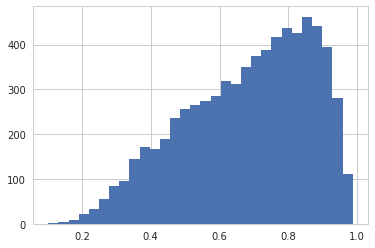

In [35]:
plt.hist(test_predictions, bins=30)
plt.show()

In [68]:
pos_example_idxs_test = np.flatnonzero(test_predictions >= pos_threshold)
neg_example_idxs_test = np.flatnonzero(test_predictions <= neg_threshold)

print('# interesting pos, X_test: ', len(pos_example_idxs_test))
print('# interesting neg, X_test: ', len(neg_example_idxs_test))

# interesting pos, X_test:  1521
# interesting neg, X_test:  939


In [59]:
brc_test = BeerReviewContainer(embeddings, index_to_token, ASPECT, model_path, 0)

In [60]:
for i in pos_example_idxs_test:
    x = X_test[i]
    review = BeerReview(x, i, embeddings=embeddings)
    review.threshold = pos_threshold
    review.threshold_f = threshold_pos_f
    review.is_pos = True
    brc_test.add_pos_review(review)

for i in neg_example_idxs_test:
    x = X_test[i]
    review = BeerReview(x, i, embeddings=embeddings)
    review.threshold = neg_threshold
    review.threshold_f = threshold_neg_f
    review.is_pos = False
    brc_test.add_neg_review(review)

In [61]:
%%time
# Compute all sufficient rationales for each review
for review in brc_test.get_all_reviews():
    review.run_sis_rationales(embed_model, first_only=False, verbose=False)

CPU times: user 7h 45min 42s, sys: 44min 19s, total: 8h 30min 1s
Wall time: 10h 54min 43s


In [62]:
BRC_TEST_DIR = '../rationale_results/beer_reviews/asp1_test_cnn'

In [63]:
# Save Test BRC to file
brc_test.dump_data(BRC_TEST_DIR)

In [ ]:
brc_test = BeerReviewContainer.load_data(BRC_TEST_DIR)